In [2]:
# Importing substantial libraries
import os

%matplotlib inline

import torch
import torch.nn as nn
import numpy as np

import random
import matplotlib.pyplot as plt
import pandas as pd
from config import get_cfg_defaults

from kale.utils.download import download_file_by_url
from kale.loaddata.image_access import read_dicom_images
from kale.interpret import visualize
from kale.embed.mpca import MPCA

from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.lines as mlines
import scipy.integrate as integrate

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from kale.pipeline.mpca_trainer import MPCATrainer
from sklearn.calibration import CalibratedClassifierCV

In [3]:
import sys
sys.path.append('../support_functions')
from reliability_diagrams import *

In [4]:
cfg_path = "/Users/matt/Desktop/Dissertation/src/Confidence Calibration/pykale/examples/cmri_mpca/configs/tutorial_svc.yaml" # Path to `.yaml` config file

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  BASE_DIR: SA_64x64
  FILE_FORAMT: zip
  IMG_DIR: DICOM
  LANDMARK_FILE: landmarks_64x64.csv
  MASK_DIR: Mask
  ROOT: ../data
  SOURCE: https://github.com/pykale/data/raw/main/images/ShefPAH-179/SA_64x64.zip
IM_KWARGS:
  cmap: gray
MARKER_KWARGS:
  marker: o
  markeredgecolor: r
  markeredgewidth: 1.5
  markerfacecolor: (1, 1, 1, 0.1)
OUTPUT:
  ROOT: ./outputs
PIPELINE:
  CLASSIFIER: svc
PROC:
  SCALE: 2
WEIGHT_KWARGS:
  alpha: 0.7
  markersize: 6


In [5]:
base_dir = cfg.DATASET.BASE_DIR
file_format = cfg.DATASET.FILE_FORAMT
download_file_by_url(cfg.DATASET.SOURCE, cfg.DATASET.ROOT, "%s.%s" % (base_dir, file_format), file_format)

In [6]:
img_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.IMG_DIR)
images = read_dicom_images(img_path, sort_instance=True, sort_patient=True)

mask_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.MASK_DIR)
mask = read_dicom_images(mask_path, sort_instance=True)

/opt/anaconda3/lib/python3.8/site-packages/pydicom/filereader.py:354: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(msg + f" - using {found_vr} VR for reading", UserWarning)


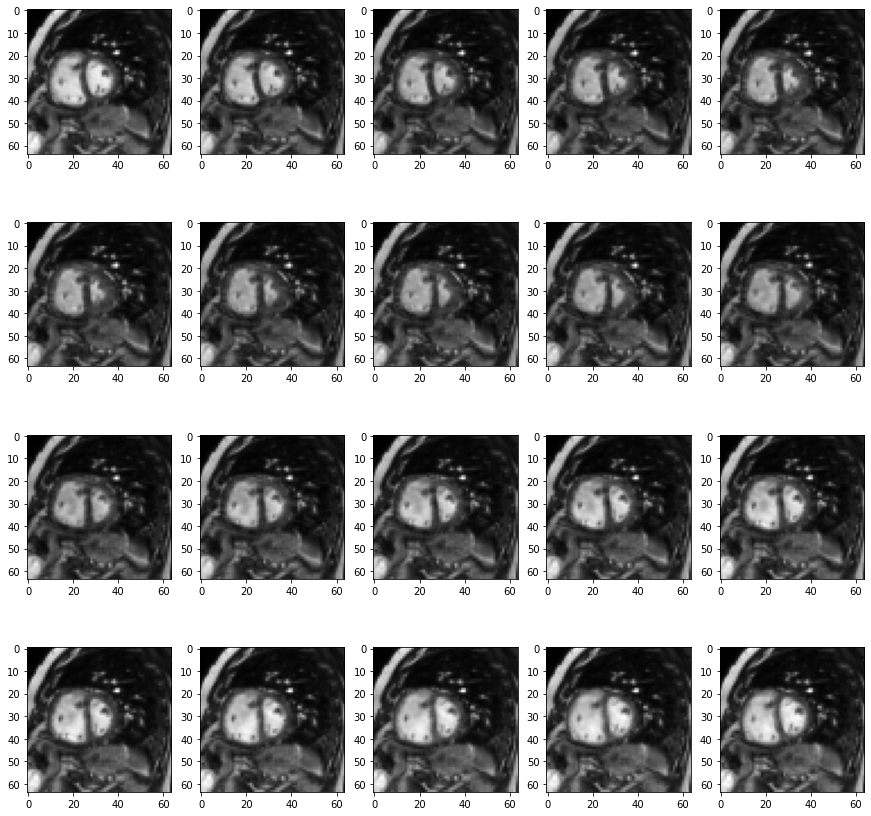

In [7]:
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(images[i][j-1], cmap="gray")

In [8]:
landmark_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.LANDMARK_FILE)
landmark_df = pd.read_csv(landmark_path, index_col="Subject")  # read .csv file as dataframe
landmarks = landmark_df.iloc[:, :6].values
y = landmark_df["Group"].values
y[np.where(y != 0)] = 1 

/var/folders/2q/3djqmyrx3wqdgl5t340yz7zw0000gn/T/ipykernel_81218/3032264643.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize.plot_multi_images(


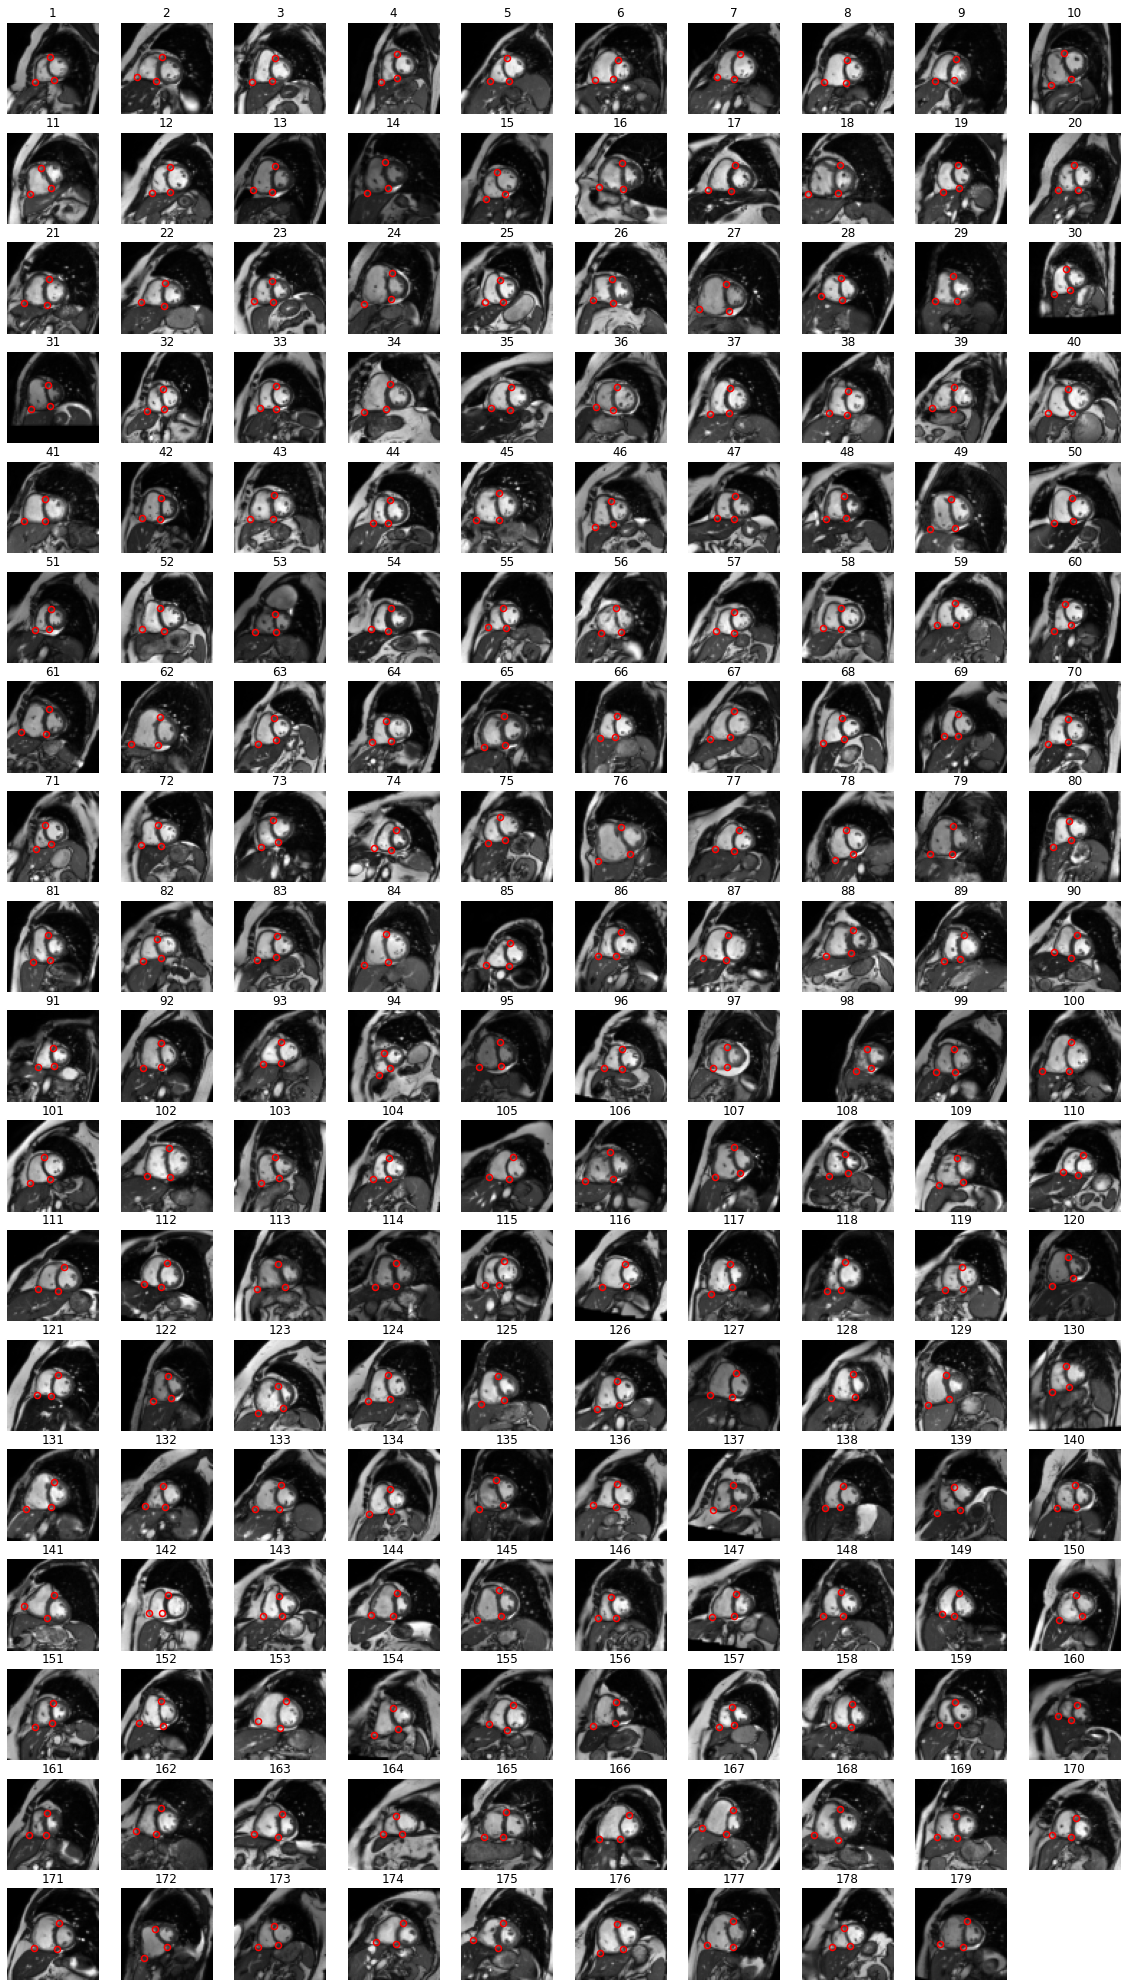

In [9]:
visualize.plot_multi_images(
    images[:, 0, ...], marker_locs=landmarks, im_kwargs=dict(cfg.IM_KWARGS), marker_kwargs=dict(cfg.MARKER_KWARGS)
).show()

In [10]:
from kale.prepdata.image_transform import mask_img_stack, normalize_img_stack, reg_img_stack, rescale_img_stack

In [11]:
img_reg, max_dist = reg_img_stack(images.copy(), landmarks)

In [12]:
img_masked = mask_img_stack(img_reg.copy(), mask[0, 0, ...])

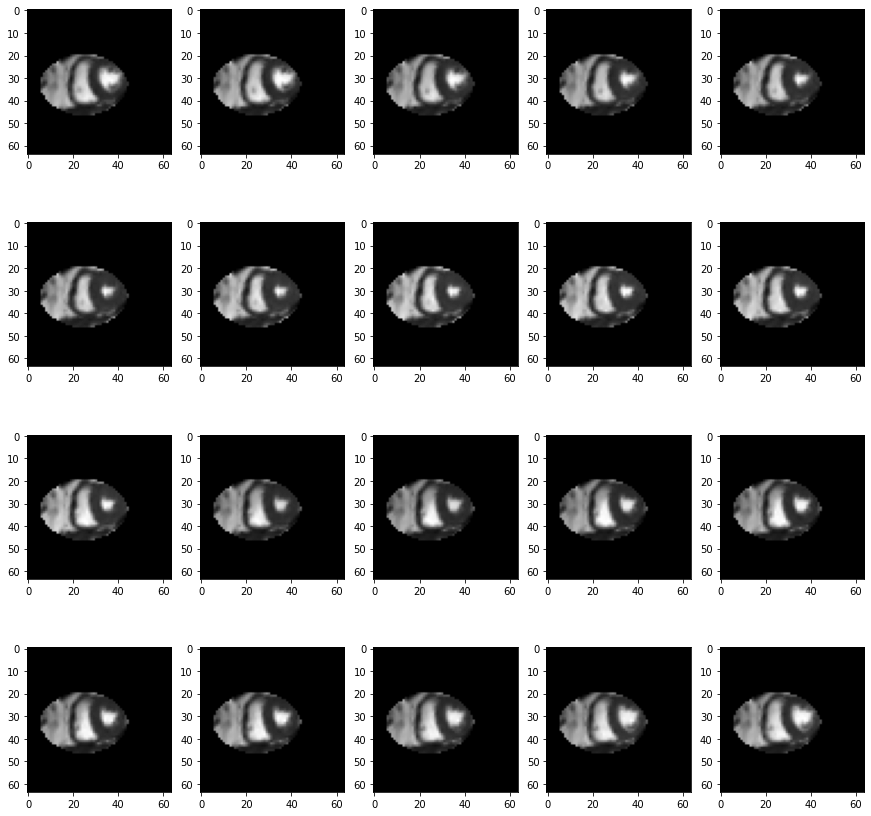

In [13]:
#Plotting masked images
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(img_masked[i][j-1], cmap="gray")

In [14]:
img_rescaled = rescale_img_stack(img_masked.copy(), scale=1 / 2)

In [15]:
img_norm = normalize_img_stack(img_rescaled.copy())

In [16]:
x = img_norm.copy()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [18]:
import torchvision.transforms as transforms
from PIL import Image
import cv2

In [19]:
!pip install albumentations
import albumentations as A

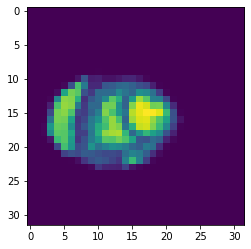

In [20]:
plt.imshow(x[0][0])
plt.show()

In [21]:
avg_acc = []
avg_ece = []
avg_log_loss = []

aug_avg_acc = []
aug_avg_ece = []
aug_avg_log_loss = []

# Physical Transformation

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [23]:
transform = A.Compose(
    [
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.9),
        A.VerticalFlip(p=0.9),
    ]
)

In [24]:
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [25]:
augmented_images.shape, len(labels)

((50, 20, 32, 32), 50)

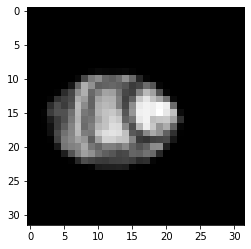

In [26]:
plt.imshow(augmented_images[8][0], cmap="gray")
plt.show()

In [27]:
y_aug = np.array(labels)
y_aug = y_aug.flatten()
y_aug.shape

(50,)

In [28]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(125,)

In [29]:
#for j in range(augmented_images.shape[0]):
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [30]:
model = MPCATrainer(classifier='svc', n_features=200)
aug_model = MPCATrainer(classifier='svc', n_features=200)
#calibrated_model.clf = CalibratedClassifierCV(calibrated_model.clf, cv=10, method='sigmoid')

In [31]:
model.fit(X_train, y_train)
aug_model.fit(X_train_aug, y_train_aug)

In [32]:
y_hat = model.predict(X_test)
y_hat_aug = aug_model.predict(X_test)

In [33]:
y_probs_0 = model.predict_proba(X_test)[:, 0]
y_probs_1 = model.predict_proba(X_test)[:, 1]
y_probs_aug_0 = aug_model.predict_proba(X_test)[:, 0]
y_probs_aug_1 = aug_model.predict_proba(X_test)[:, 1]

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


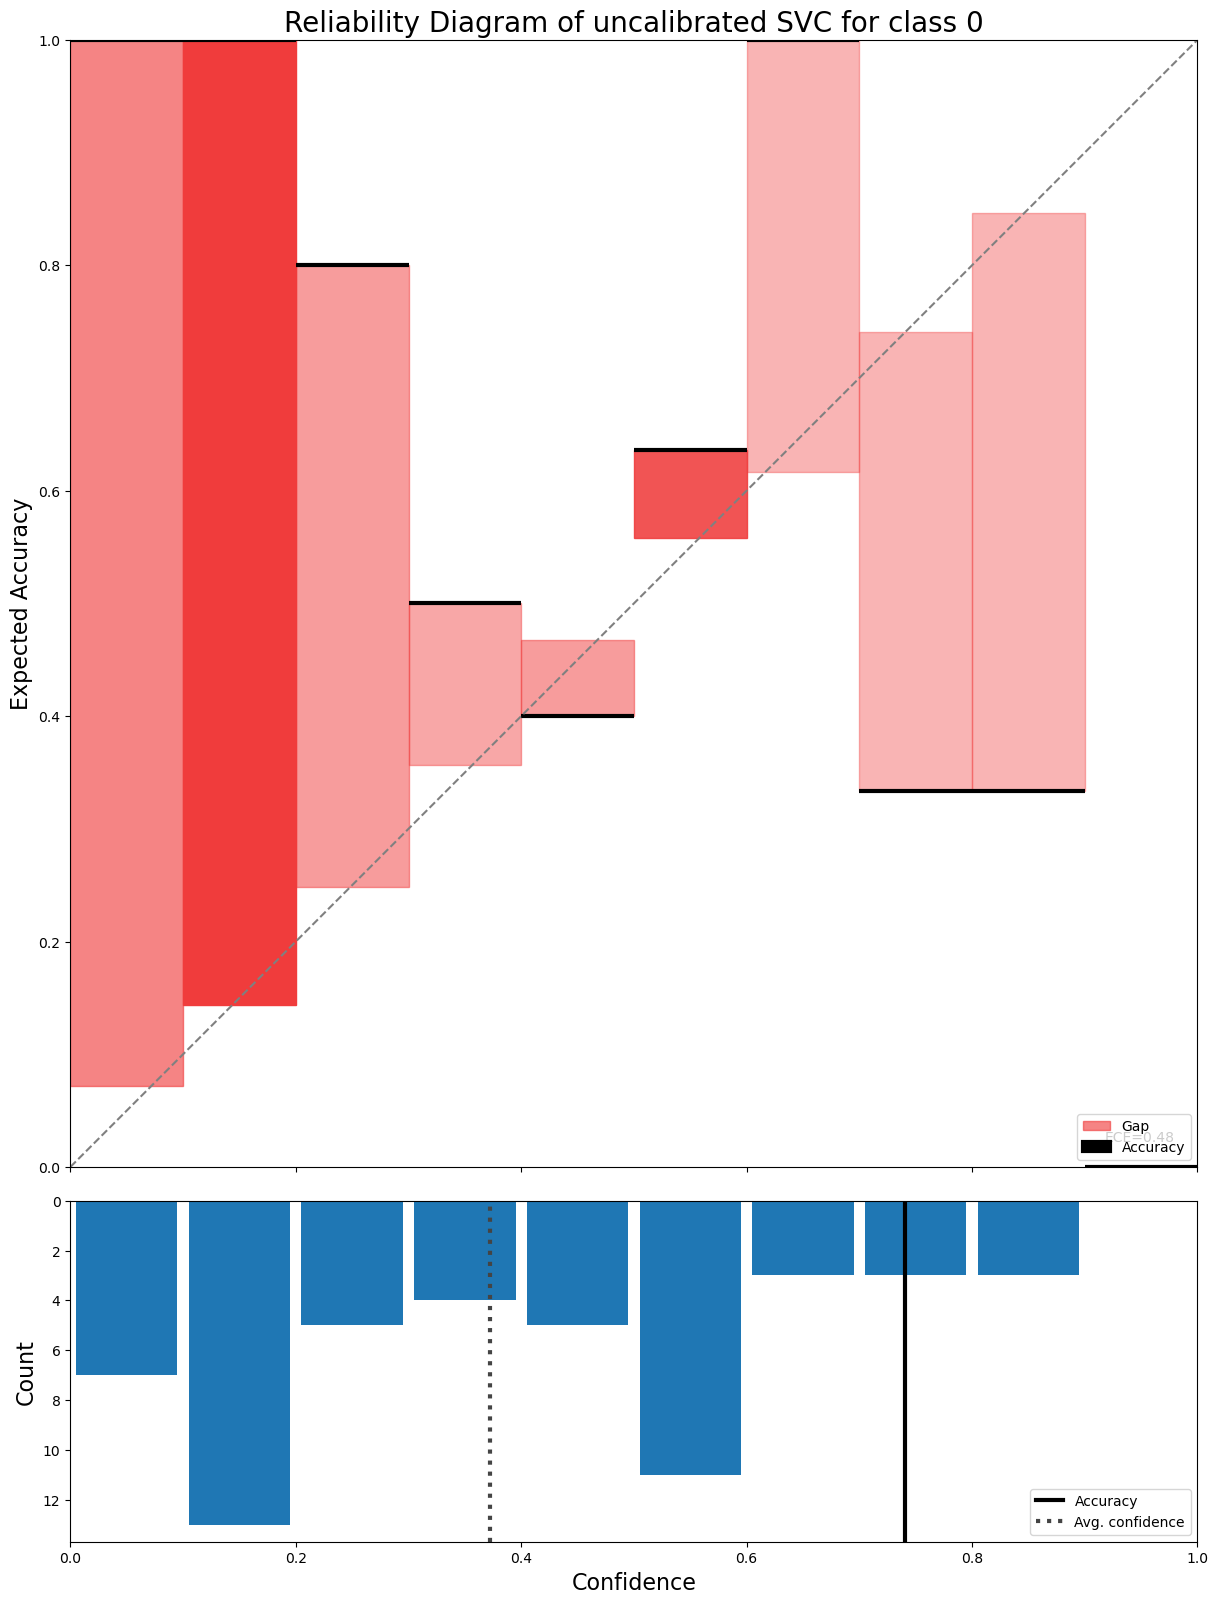

In [34]:
fig = reliability_diagram(y_test, y_hat, y_probs_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of uncalibrated SVC for class 0.jpg", bbox_inches='tight')

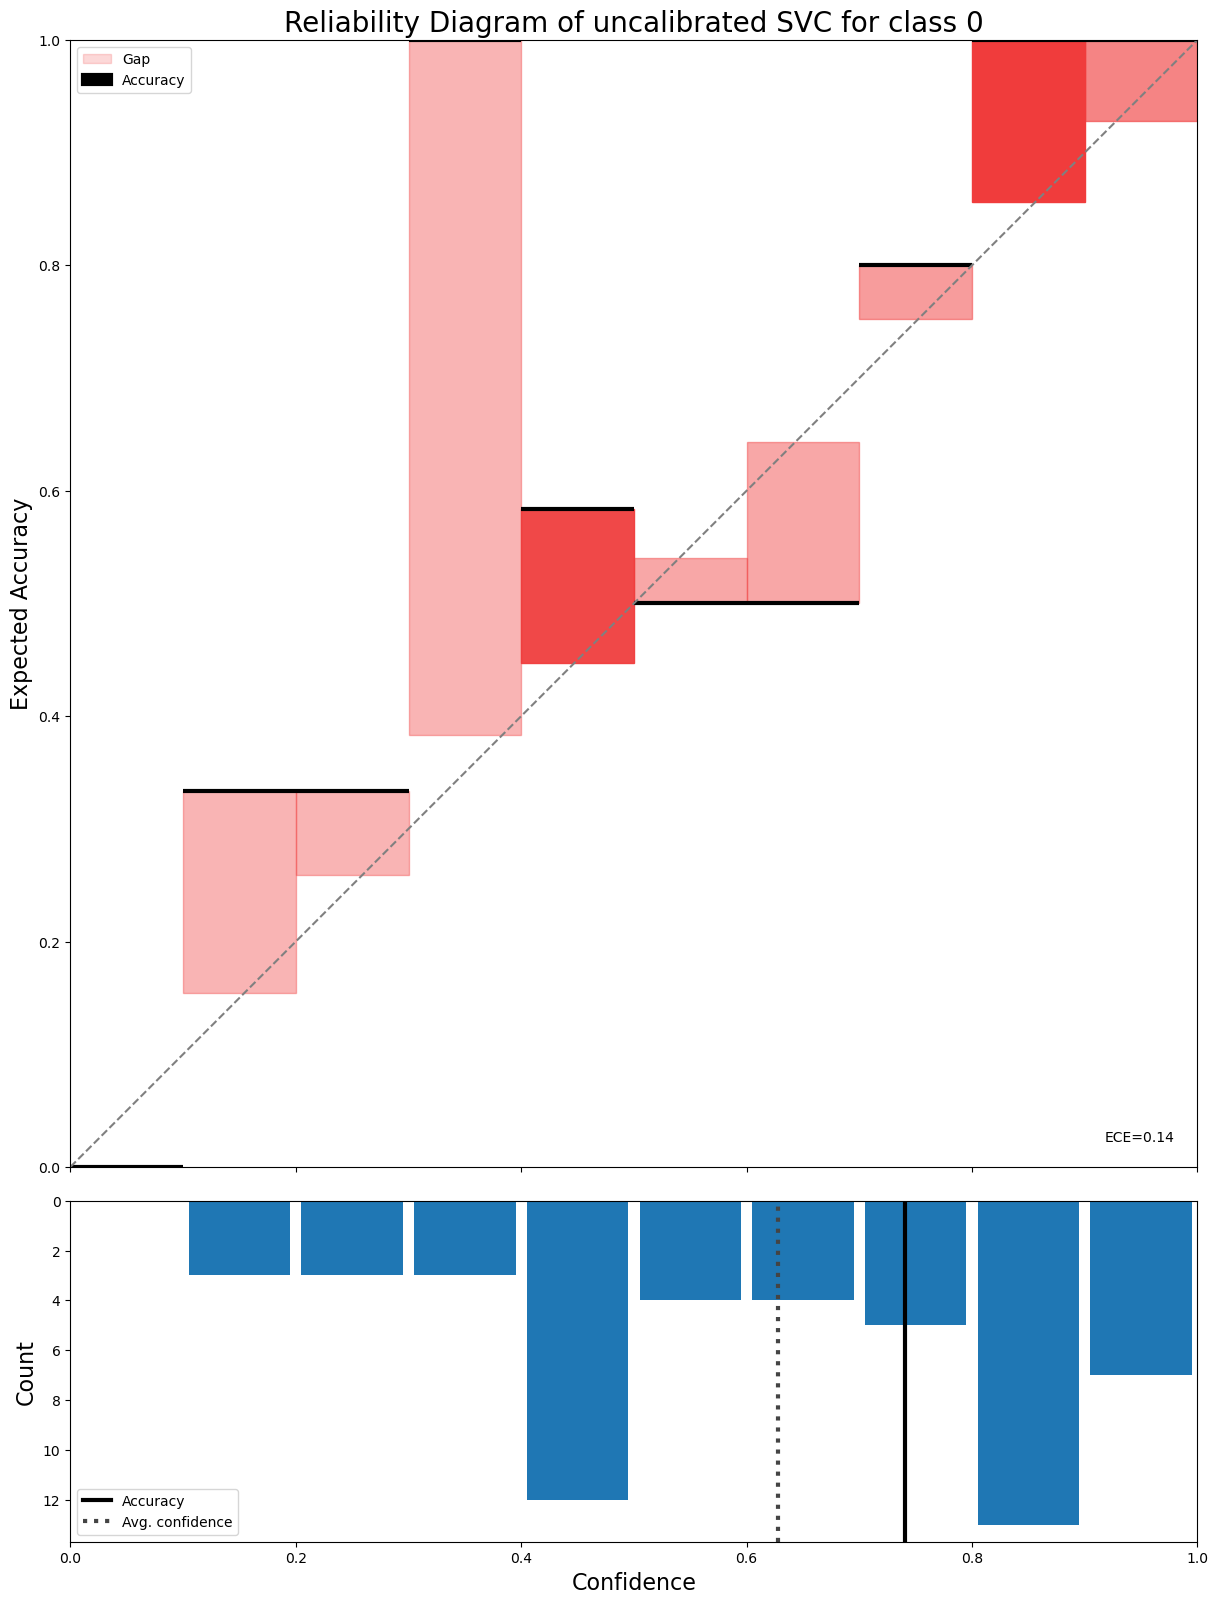

In [35]:
fig = reliability_diagram(y_test, y_hat, y_probs_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of uncalibrated SVC for class 0.jpg", bbox_inches='tight')

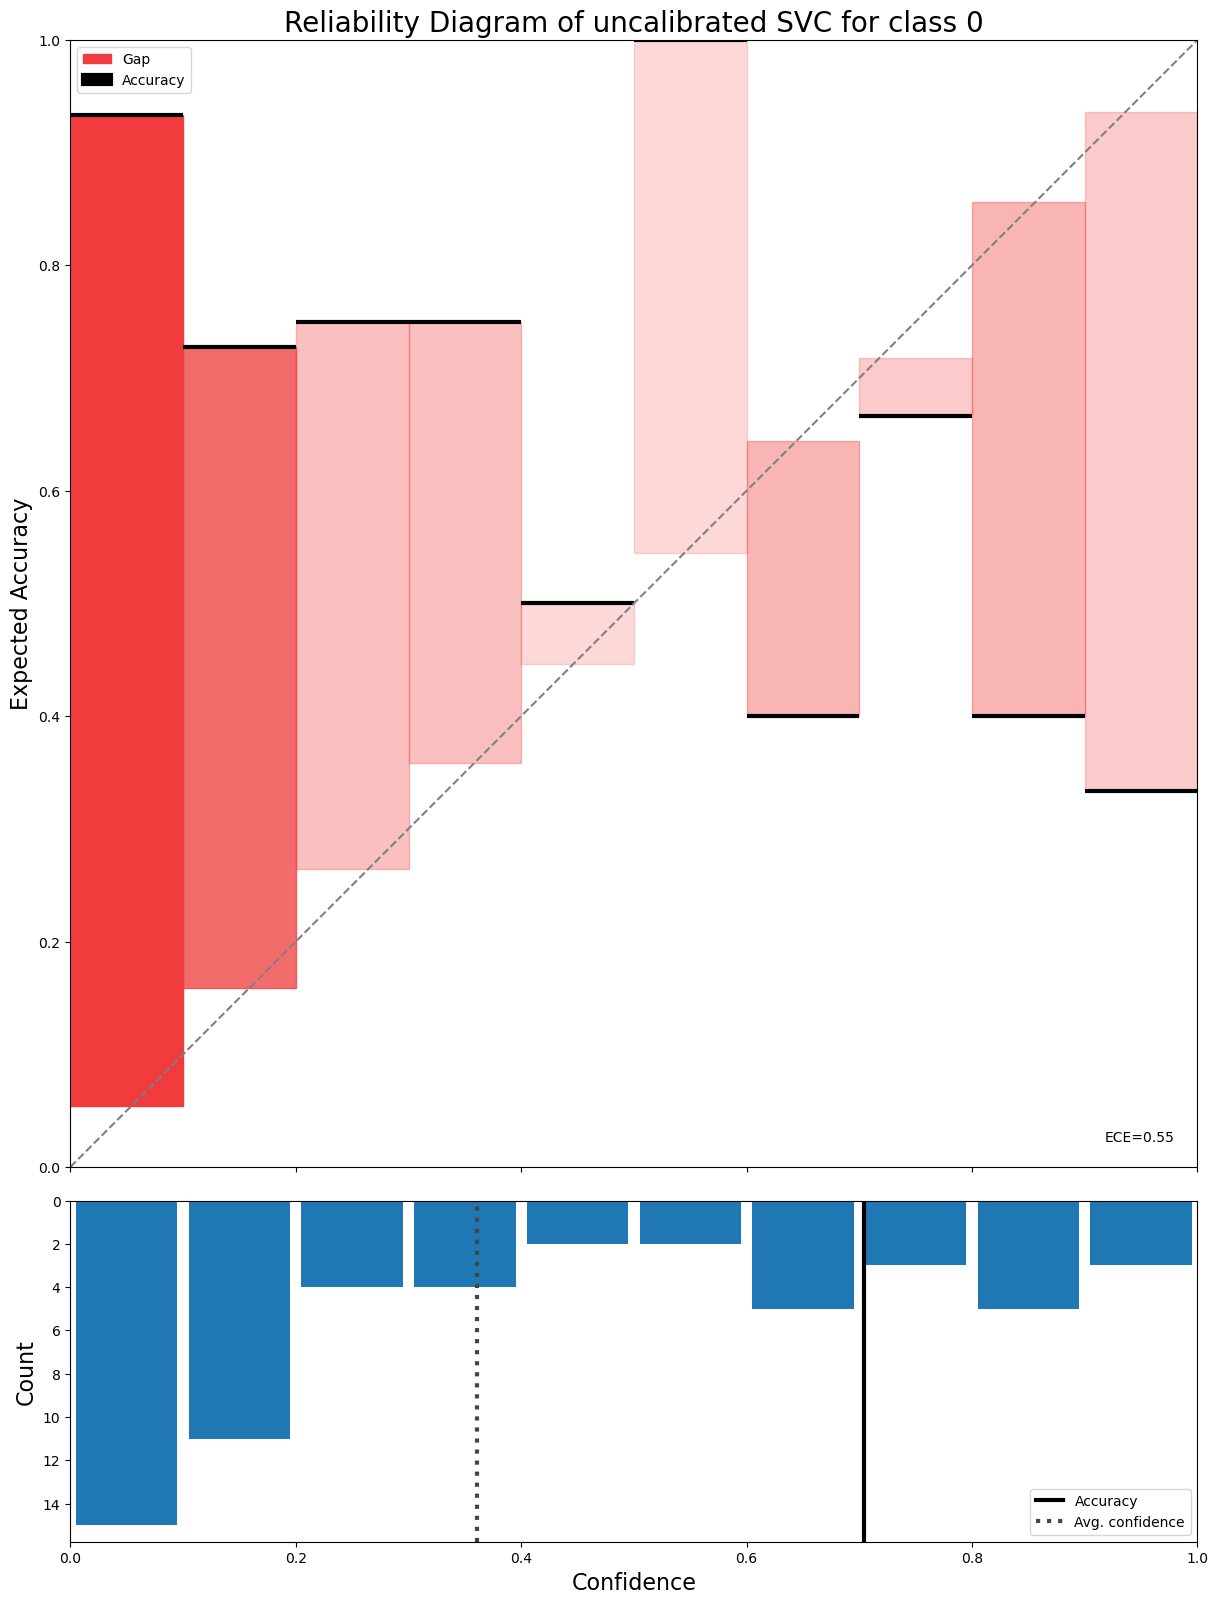

In [36]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of uncalibrated SVC for class 0.jpg", bbox_inches='tight')

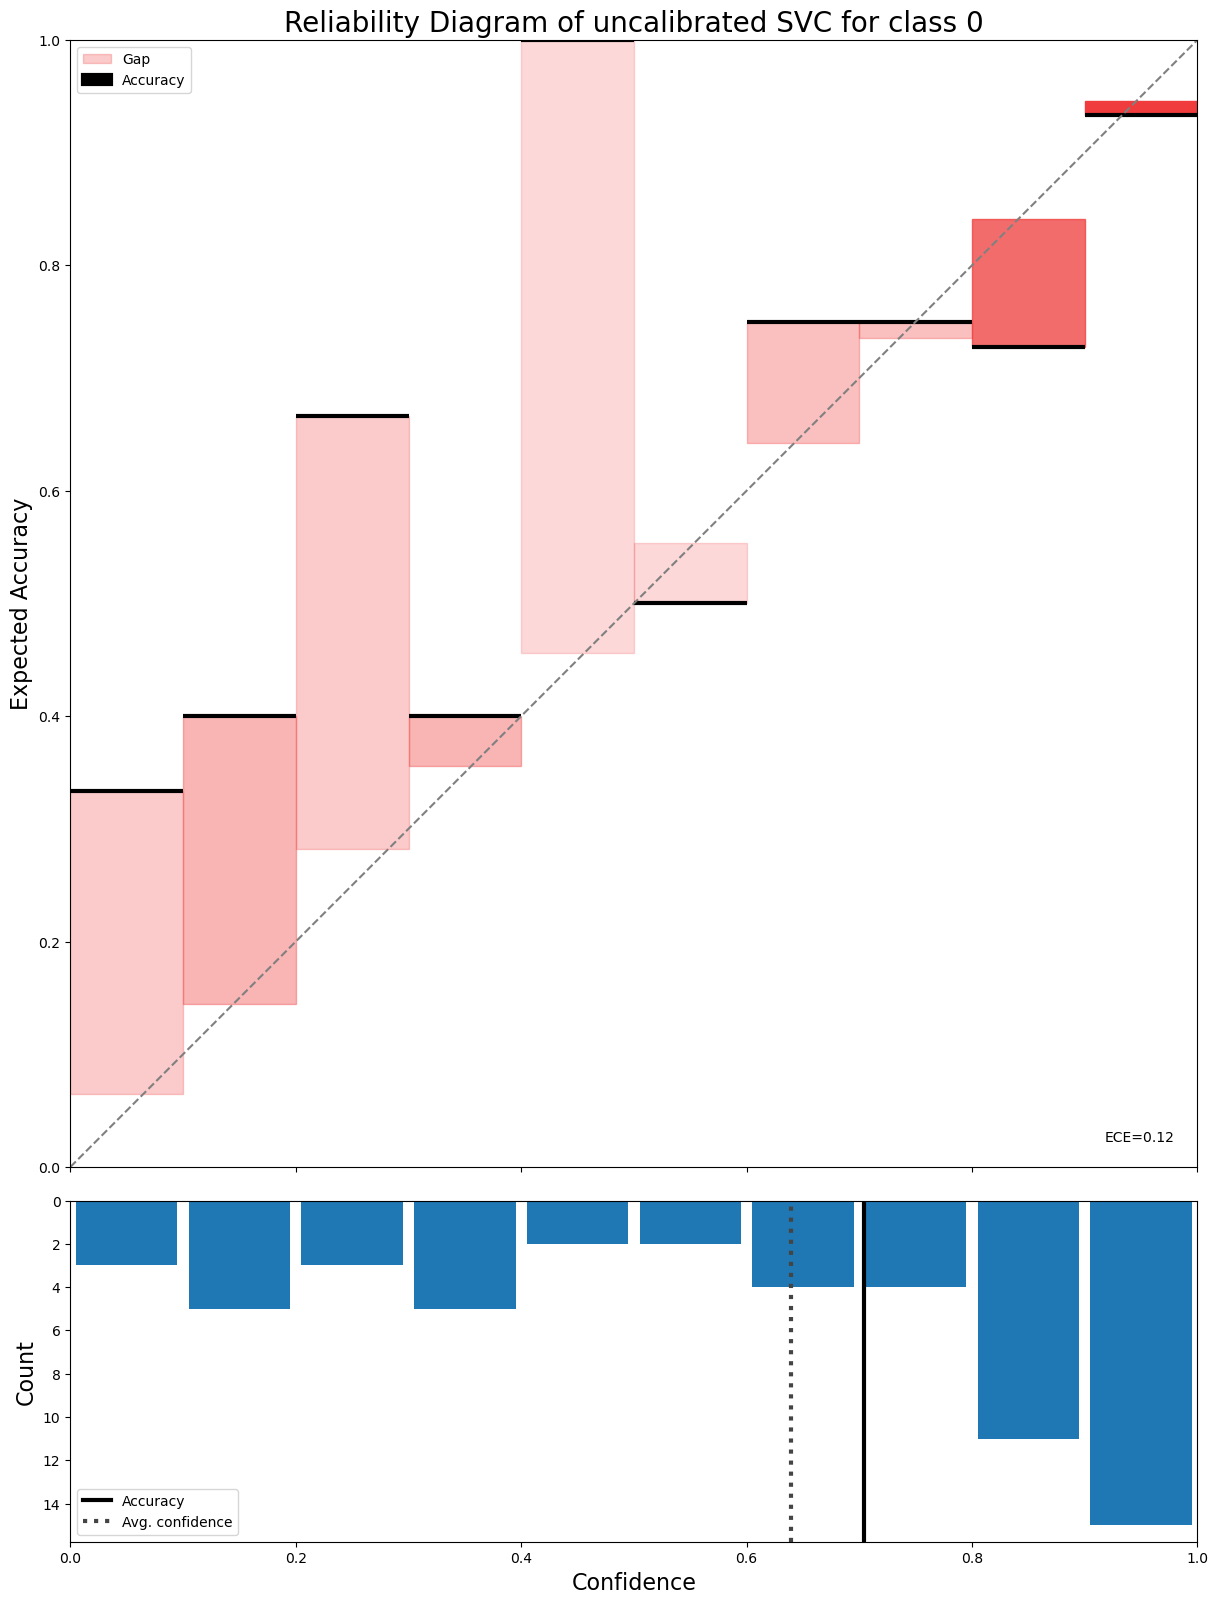

In [37]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of uncalibrated SVC for class 0.jpg", bbox_inches='tight')

In [38]:
calibration_scores_class_0 = compute_calibration(y_test, y_hat, y_probs_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([1.        , 1.        , 0.8       , 0.5       , 0.4       ,
        0.63636364, 1.        , 0.33333333, 0.33333333, 0.        ]),
 'confidences': array([0.0718346 , 0.14349397, 0.24794705, 0.35651375, 0.46748159,
        0.55761287, 0.61697545, 0.74105836, 0.84601999, 0.        ]),
 'counts': array([ 7, 13,  5,  4,  5, 11,  3,  3,  3,  0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7407407407407407,
 'avg_confidence': 0.3725437946542228,
 'expected_calibration_error': 0.48296150067170096,
 'max_calibration_error': 0.9281654044721791}

In [39]:
calibration_scores_class_1 = compute_calibration(y_test, y_hat, y_probs_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.        , 0.33333333, 0.33333333, 1.        , 0.58333333,
        0.5       , 0.5       , 0.8       , 1.        , 1.        ]),
 'confidences': array([0.        , 0.15398001, 0.25894164, 0.38302455, 0.4471882 ,
        0.54064802, 0.64348625, 0.75205295, 0.85650603, 0.9281654 ]),
 'counts': array([ 0,  3,  3,  3, 12,  4,  4,  5, 13,  7]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7407407407407407,
 'avg_confidence': 0.6274562053457772,
 'expected_calibration_error': 0.14056368653094264,
 'max_calibration_error': 0.6169754453944984}

In [40]:
aug_calibration_scores_class_0 = compute_calibration(y_test, y_hat_aug, y_probs_aug_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([1.        , 1.        , 0.8       , 0.5       , 0.4       ,
        0.63636364, 1.        , 0.33333333, 0.33333333, 0.        ]),
 'confidences': array([0.0718346 , 0.14349397, 0.24794705, 0.35651375, 0.46748159,
        0.55761287, 0.61697545, 0.74105836, 0.84601999, 0.        ]),
 'counts': array([ 7, 13,  5,  4,  5, 11,  3,  3,  3,  0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7407407407407407,
 'avg_confidence': 0.3725437946542228,
 'expected_calibration_error': 0.48296150067170096,
 'max_calibration_error': 0.9281654044721791}

In [41]:
aug_calibration_scores_class_1 = compute_calibration(y_test, y_hat_aug, y_probs_aug_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.        , 0.33333333, 0.33333333, 1.        , 0.58333333,
        0.5       , 0.5       , 0.8       , 1.        , 1.        ]),
 'confidences': array([0.        , 0.15398001, 0.25894164, 0.38302455, 0.4471882 ,
        0.54064802, 0.64348625, 0.75205295, 0.85650603, 0.9281654 ]),
 'counts': array([ 0,  3,  3,  3, 12,  4,  4,  5, 13,  7]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7407407407407407,
 'avg_confidence': 0.6274562053457772,
 'expected_calibration_error': 0.14056368653094264,
 'max_calibration_error': 0.6169754453944984}

In [42]:
log_loss_class_0 = log_loss(y_test, y_probs_0)
log_loss_class_1 = log_loss(y_test, y_probs_1)
avrg_log_loss = (log_loss_class_0 + log_loss_class_1)/2

ece_class_0 = calibration_scores_class_0["expected_calibration_error"]
ece_class_1 = calibration_scores_class_1["expected_calibration_error"]
avrg_ece = (ece_class_0 + ece_class_1)/2

In [43]:
avrg_ece, avrg_log_loss, calibration_scores_class_0["avg_accuracy"]

(0.3117625936013218, 0.9162340495127901, 0.7407407407407407)

In [44]:
avg_ece.append(avrg_ece)
avg_log_loss.append(avrg_log_loss)
avg_acc.append(calibration_scores_class_0["avg_accuracy"])

In [45]:
aug_log_loss_class_0 = log_loss(y_test, y_probs_aug_0)
aug_log_loss_class_1 = log_loss(y_test, y_probs_aug_1)
aug_avrg_log_loss = (aug_log_loss_class_0 + aug_log_loss_class_1)/2

aug_ece_class_0 = aug_calibration_scores_class_0["expected_calibration_error"]
aug_ece_class_1 = aug_calibration_scores_class_1["expected_calibration_error"]
aug_avrg_ece = (aug_ece_class_0 + aug_ece_class_1)/2

In [46]:
aug_avrg_ece, aug_avrg_log_loss, aug_calibration_scores_class_0["avg_accuracy"]

(0.33352443289768874, 1.106615261438898, 0.7037037037037037)

In [47]:
aug_avg_ece.append(aug_avrg_ece)
aug_avg_log_loss.append(aug_avrg_log_loss)
aug_avg_acc.append(aug_calibration_scores_class_0["avg_accuracy"])

In [48]:
# Think aout how exactly should you design this data augmentation experiments.

In [49]:
len(avg_ece)

1

In [50]:
np.std(avg_ece)/np.sqrt(len(avg_ece)), np.std(avg_log_loss)/np.sqrt(len(avg_log_loss)), np.std(avg_acc)/np.sqrt(len(avg_acc)) # calculating standard errors

(0.0, 0.0, 0.0)

In [51]:
np.std(aug_avg_ece)/np.sqrt(len(aug_avg_ece)), np.std(aug_avg_log_loss)/np.sqrt(len(aug_avg_log_loss)), np.std(aug_avg_acc)/np.sqrt(len(aug_avg_acc)) # calculating standard errors

(0.0, 0.0, 0.0)

In [52]:
np.mean(avg_ece), np.mean(avg_log_loss), np.mean(avg_acc) # calculating standard errors

(0.3117625936013218, 0.9162340495127901, 0.7407407407407407)

In [53]:
np.mean(aug_avg_ece), np.mean(aug_avg_log_loss), np.mean(aug_avg_acc)# calculating standard errors

(0.33352443289768874, 1.106615261438898, 0.7037037037037037)

# Colour Transformation

In [54]:
x = x.astype(np.float32)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [56]:
transform_colors = A.Compose(
    [
        A.RandomGamma(gamma_limit=(20, 180), always_apply=False, p=0.7),
        A.RandomContrast(limit=0.2, always_apply=False, p=0.6),
        A.RandomBrightness(limit=0.2, always_apply=False, p=0.6)
    ]
)

/opt/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [57]:
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform_colors(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [58]:
y_aug = np.array(labels)
y_aug = y_aug.flatten()
y_aug.shape

(50,)

In [59]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(125,)

In [60]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [61]:
X_train_aug.shape

(175, 20, 32, 32)

In [62]:
model = MPCATrainer(classifier='svc', n_features=200)
aug_model = MPCATrainer(classifier='svc', n_features=200)

In [63]:
model.fit(X_train, y_train)
aug_model.fit(X_train_aug, y_train_aug)

In [64]:
y_hat = model.predict(X_test)
y_hat_aug = aug_model.predict(X_test)

In [65]:
y_probs_0 = model.predict_proba(X_test)[:, 0]
y_probs_1 = model.predict_proba(X_test)[:, 1]
y_probs_aug_0 = aug_model.predict_proba(X_test)[:, 0]
y_probs_aug_1 = aug_model.predict_proba(X_test)[:, 1]

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


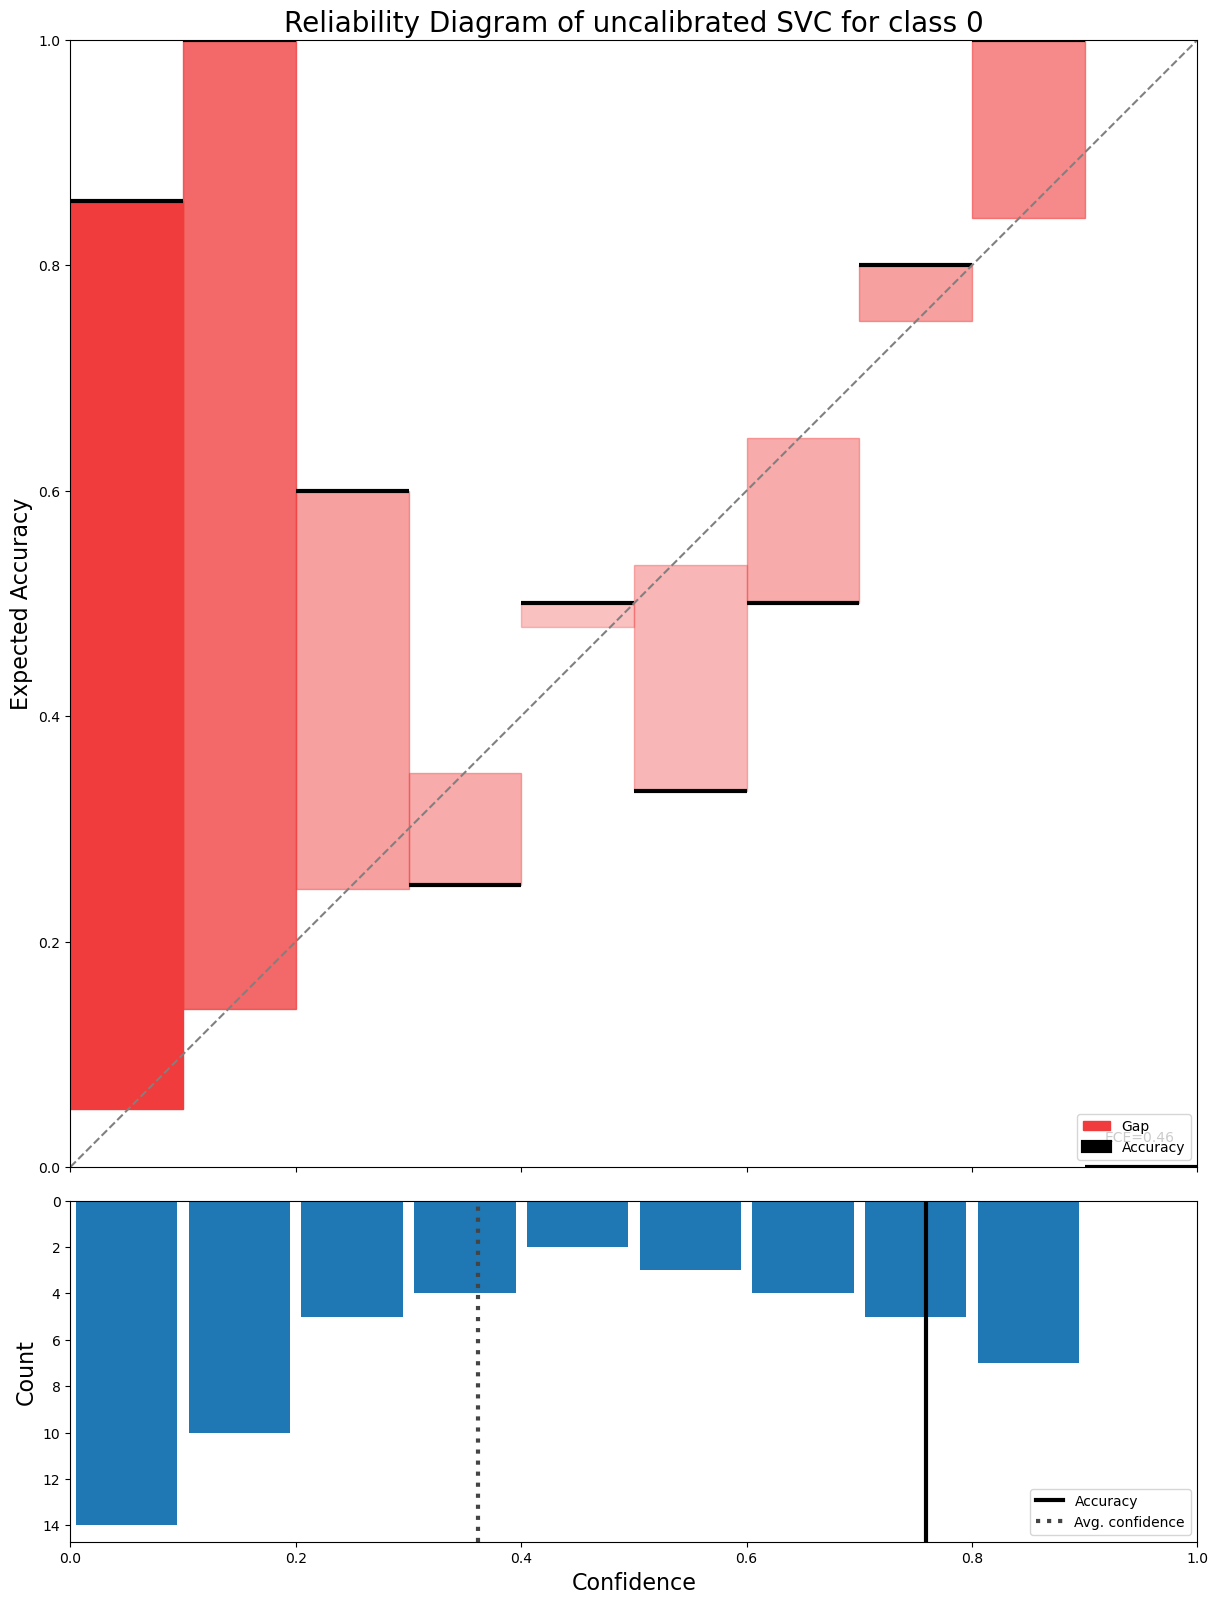

In [66]:
fig = reliability_diagram(y_test, y_hat, y_probs_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

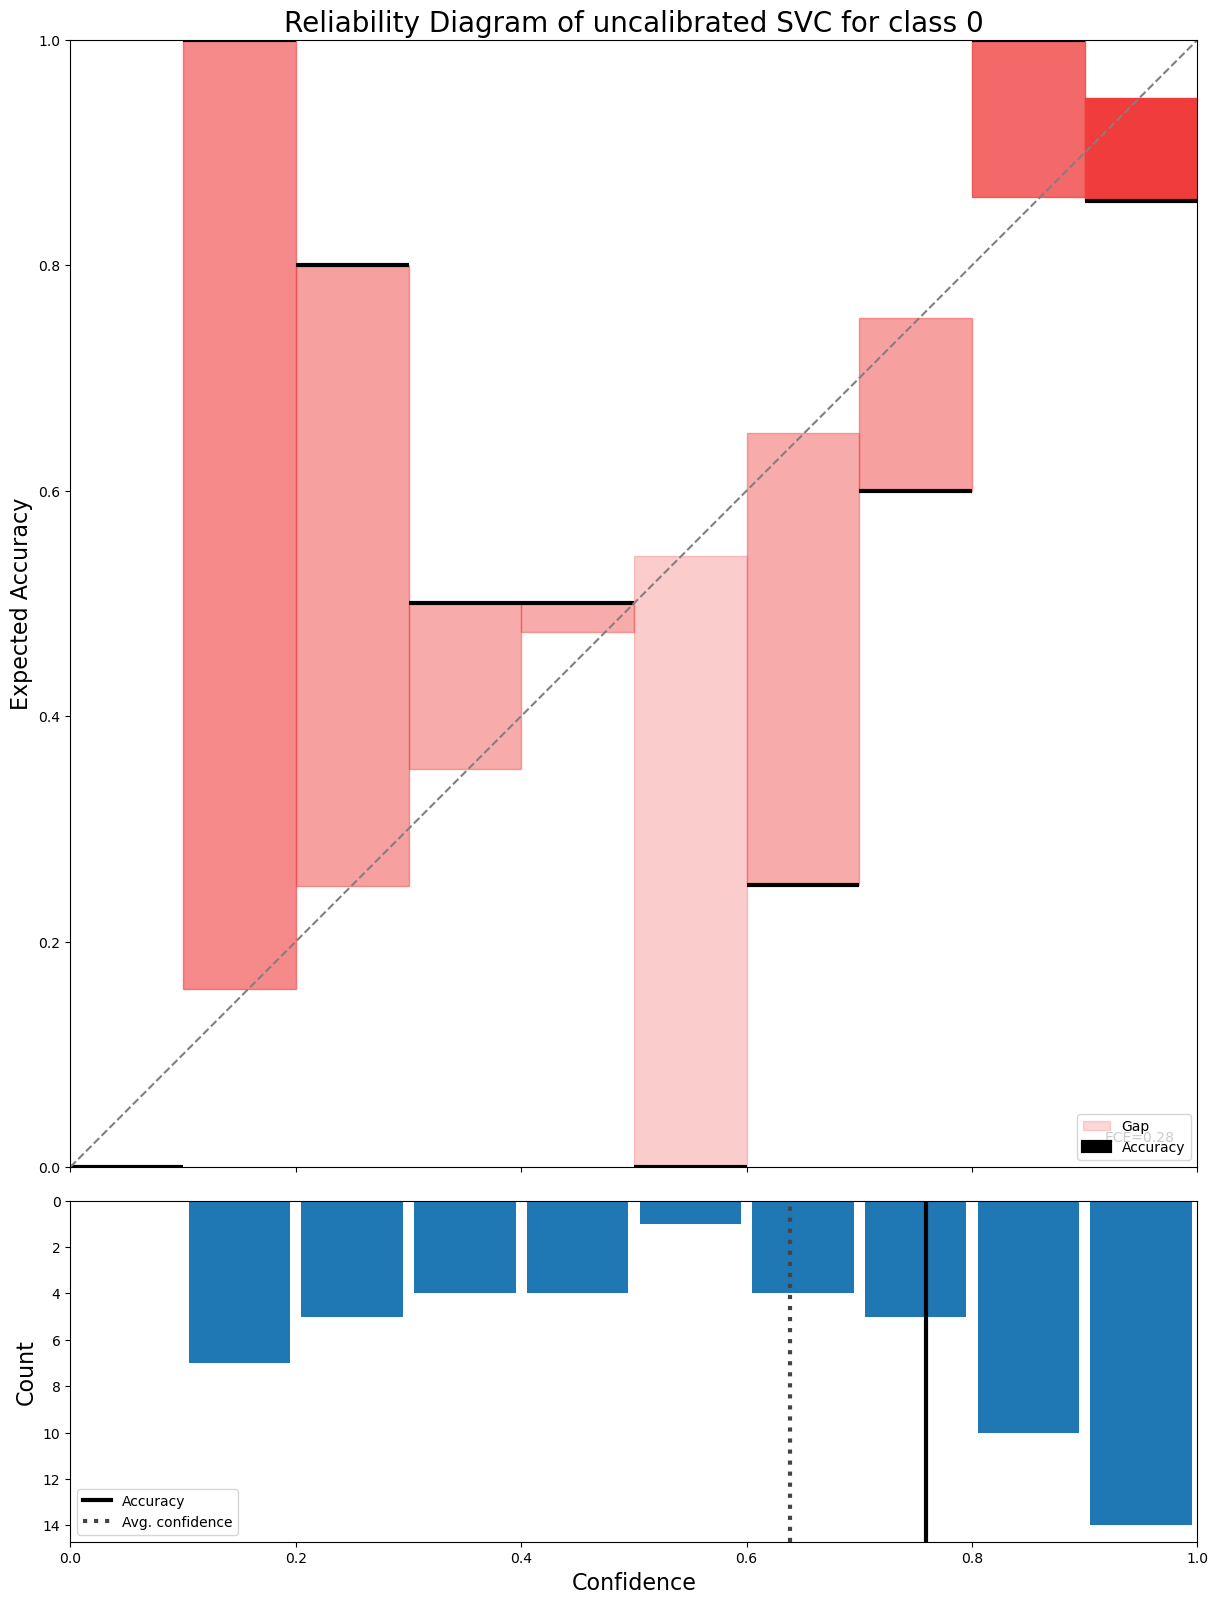

In [67]:
fig = reliability_diagram(y_test, y_hat, y_probs_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

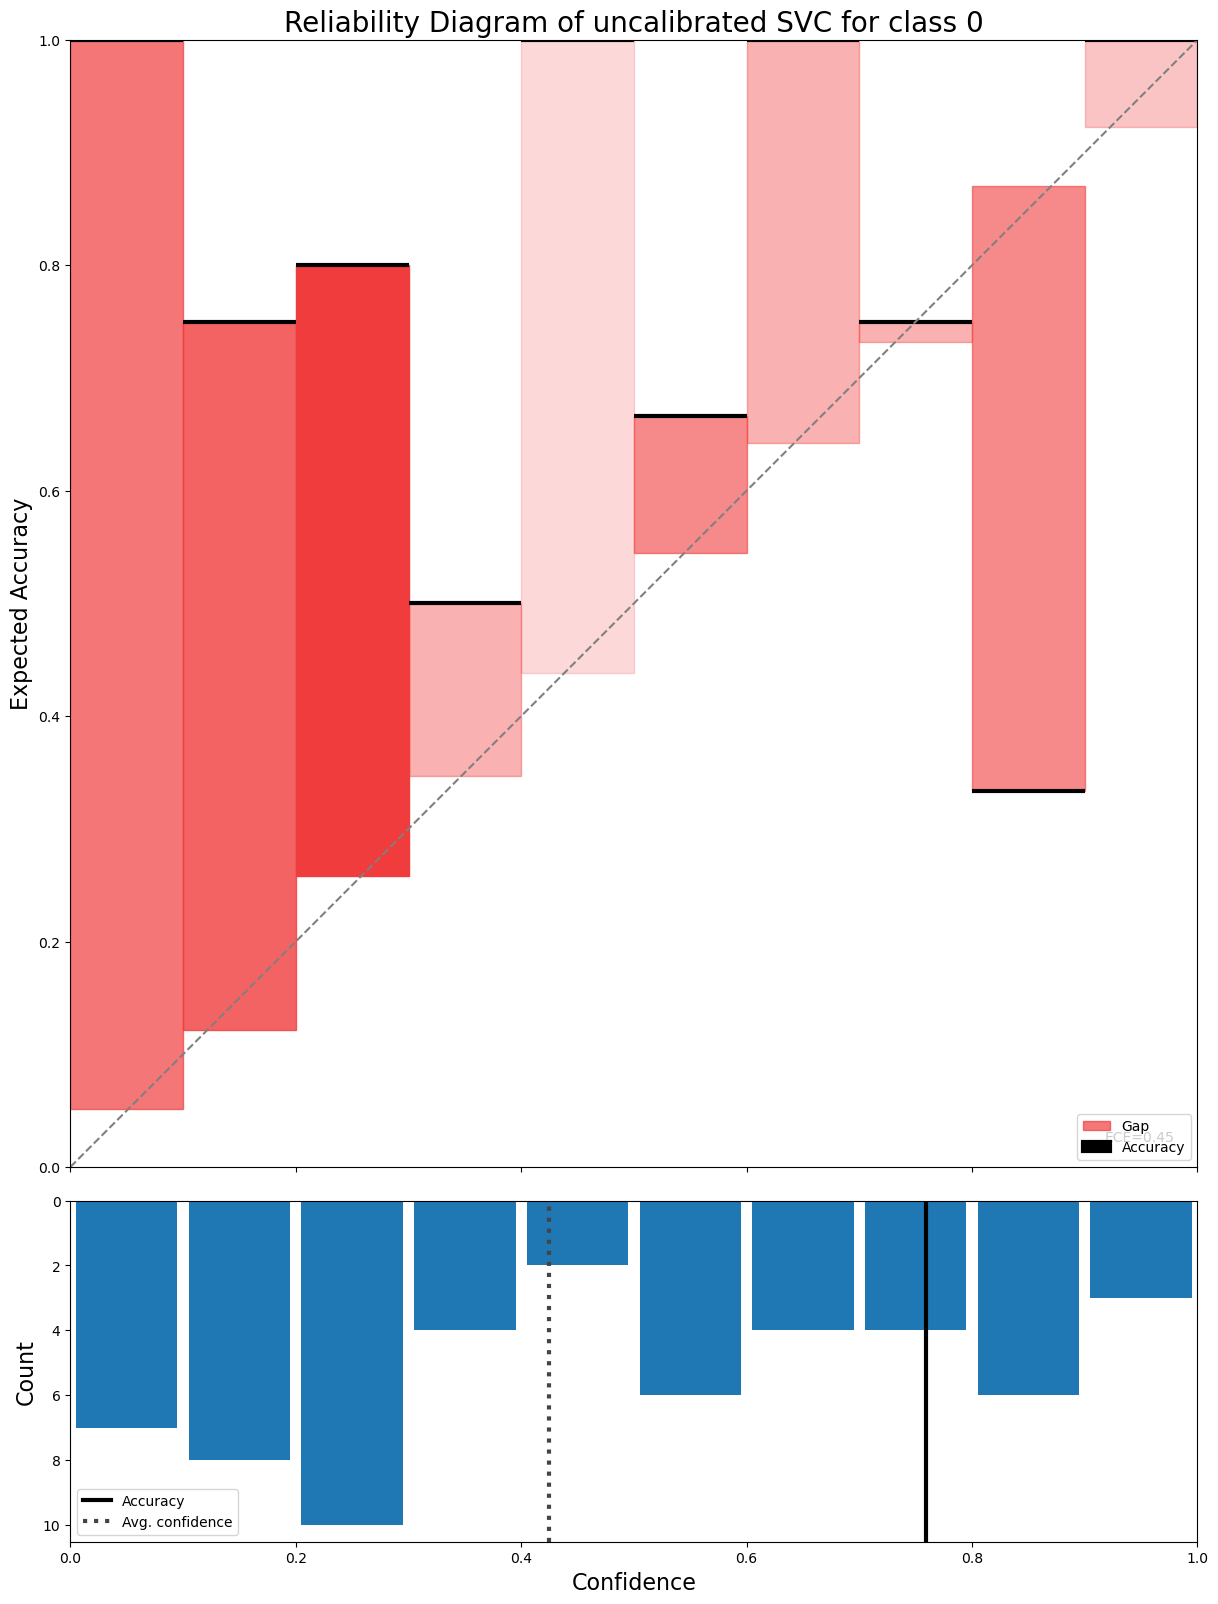

In [68]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

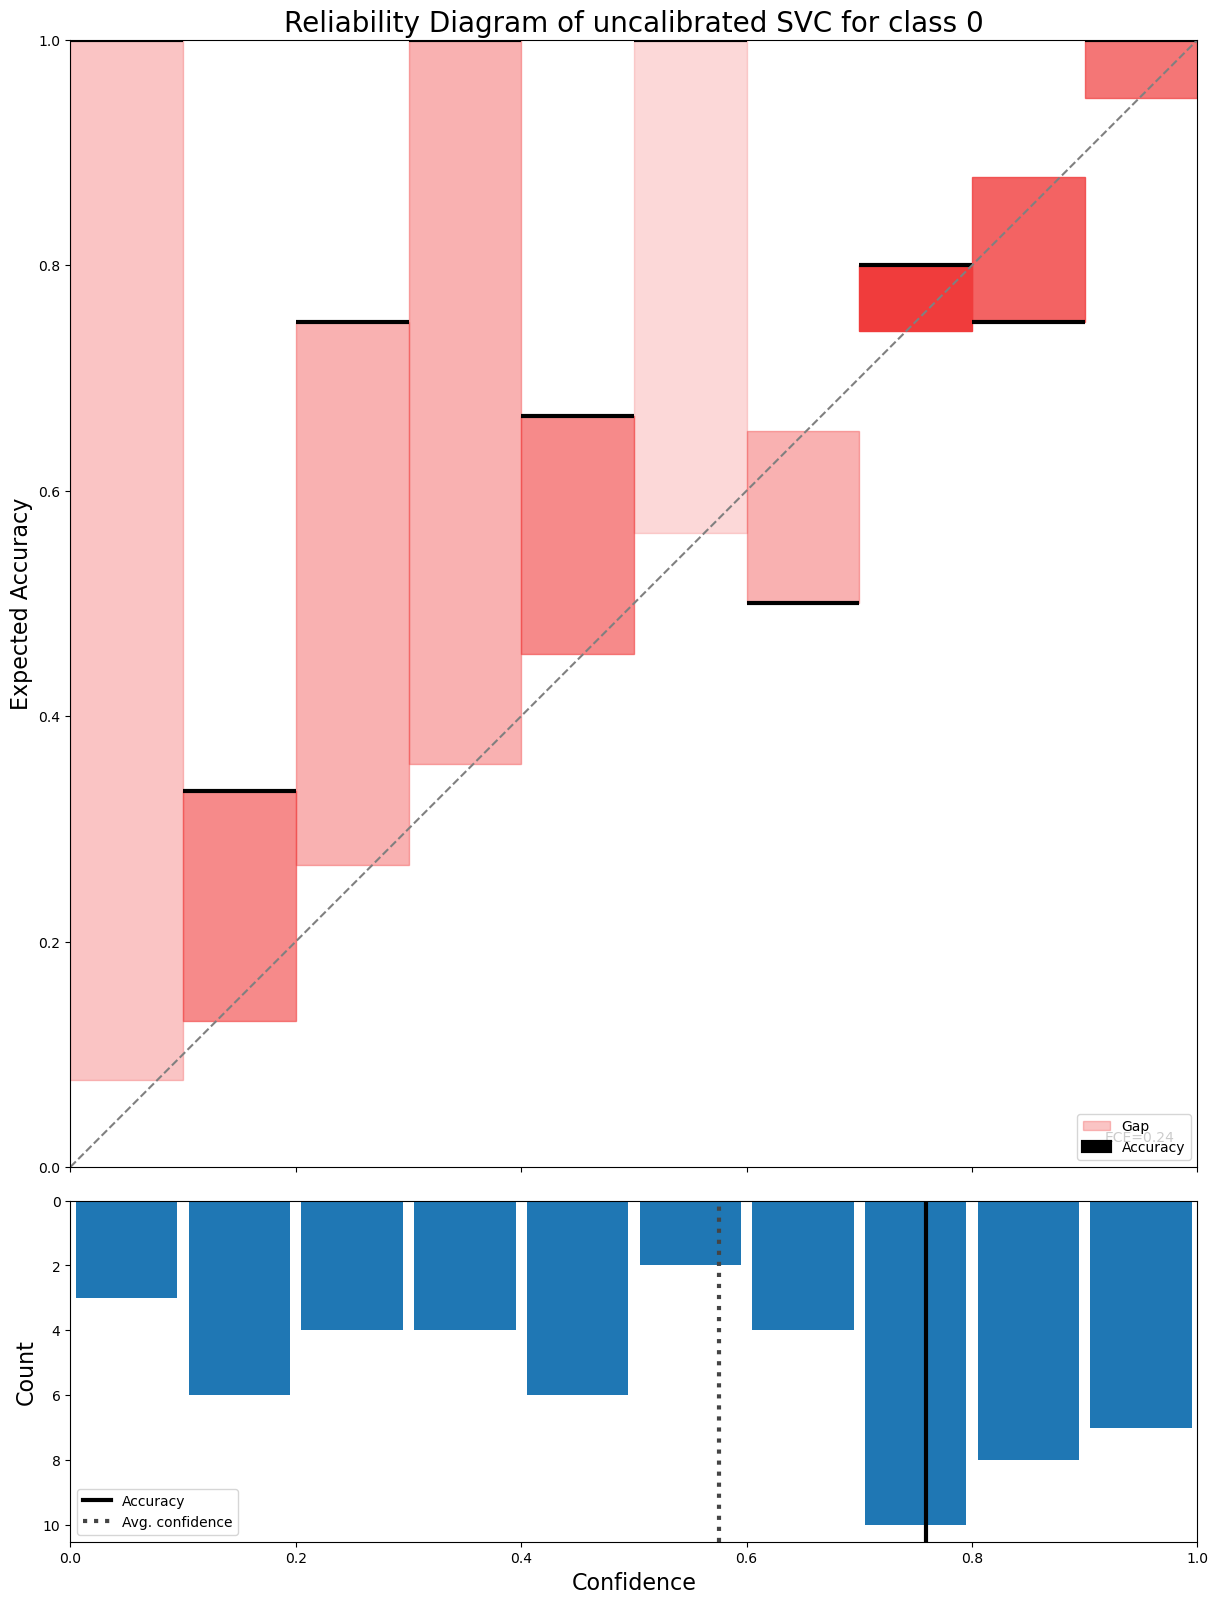

In [69]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of uncalibrated SVC for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

In [70]:
calibration_scores_class_0 = compute_calibration(y_test, y_hat, y_probs_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.85714286, 1.        , 0.6       , 0.25      , 0.5       ,
        0.33333333, 0.5       , 0.8       , 1.        , 0.        ]),
 'confidences': array([0.05166984, 0.13971   , 0.24659019, 0.34908057, 0.47909321,
        0.53415659, 0.64663234, 0.75033174, 0.84190756, 0.        ]),
 'counts': array([14, 10,  5,  4,  2,  3,  4,  5,  7,  0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7592592592592593,
 'avg_confidence': 0.3618879303968716,
 'expected_calibration_error': 0.4560869366415589,
 'max_calibration_error': 0.8602899981619405}

In [71]:
calibration_scores_class_1 = compute_calibration(y_test, y_hat, y_probs_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.        , 1.        , 0.8       , 0.5       , 0.5       ,
        0.        , 0.25      , 0.6       , 1.        , 0.85714286]),
 'confidences': array([0.        , 0.15809244, 0.24966826, 0.35336766, 0.47438256,
        0.54181357, 0.65091943, 0.75340981, 0.86029   , 0.94833016]),
 'counts': array([ 0,  7,  5,  4,  4,  1,  4,  5, 10, 14]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7592592592592593,
 'avg_confidence': 0.6381120696031283,
 'expected_calibration_error': 0.27630135660205357,
 'max_calibration_error': 0.8419075584531429}

In [72]:
aug_calibration_scores_class_0 = compute_calibration(y_test, y_hat_aug, y_probs_aug_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.85714286, 1.        , 0.6       , 0.25      , 0.5       ,
        0.33333333, 0.5       , 0.8       , 1.        , 0.        ]),
 'confidences': array([0.05166984, 0.13971   , 0.24659019, 0.34908057, 0.47909321,
        0.53415659, 0.64663234, 0.75033174, 0.84190756, 0.        ]),
 'counts': array([14, 10,  5,  4,  2,  3,  4,  5,  7,  0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7592592592592593,
 'avg_confidence': 0.3618879303968716,
 'expected_calibration_error': 0.4560869366415589,
 'max_calibration_error': 0.8602899981619405}

In [73]:
aug_calibration_scores_class_1 = compute_calibration(y_test, y_hat_aug, y_probs_aug_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.        , 1.        , 0.8       , 0.5       , 0.5       ,
        0.        , 0.25      , 0.6       , 1.        , 0.85714286]),
 'confidences': array([0.        , 0.15809244, 0.24966826, 0.35336766, 0.47438256,
        0.54181357, 0.65091943, 0.75340981, 0.86029   , 0.94833016]),
 'counts': array([ 0,  7,  5,  4,  4,  1,  4,  5, 10, 14]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7592592592592593,
 'avg_confidence': 0.6381120696031283,
 'expected_calibration_error': 0.27630135660205357,
 'max_calibration_error': 0.8419075584531429}

In [74]:
log_loss_class_0 = log_loss(y_test, y_probs_0)
log_loss_class_1 = log_loss(y_test, y_probs_1)
avrg_log_loss = (log_loss_class_0 + log_loss_class_1)/2

ece_class_0 = calibration_scores_class_0["expected_calibration_error"]
ece_class_1 = calibration_scores_class_1["expected_calibration_error"]
avrg_ece = (ece_class_0 + ece_class_1)/2

In [75]:
avrg_ece, avrg_log_loss, calibration_scores_class_0["avg_accuracy"]

(0.36619414662180627, 1.0684025604134706, 0.7592592592592593)

In [76]:
aug_log_loss_class_0 = log_loss(y_test, y_probs_aug_0)
aug_log_loss_class_1 = log_loss(y_test, y_probs_aug_1)
aug_avrg_log_loss = (aug_log_loss_class_0 + aug_log_loss_class_1)/2

aug_ece_class_0 = aug_calibration_scores_class_0["expected_calibration_error"]
aug_ece_class_1 = aug_calibration_scores_class_1["expected_calibration_error"]
aug_avrg_ece = (aug_ece_class_0 + aug_ece_class_1)/2

In [77]:
aug_avrg_ece, aug_avrg_log_loss, aug_calibration_scores_class_0["avg_accuracy"]

(0.3492266581014856, 0.9985273565902171, 0.7592592592592593)

In [78]:
avg_ece.append(avrg_ece)
avg_log_loss.append(avrg_log_loss)
avg_acc.append(calibration_scores_class_0["avg_accuracy"])

aug_avg_ece.append(aug_avrg_ece)
aug_avg_log_loss.append(aug_avrg_log_loss)
aug_avg_acc.append(aug_calibration_scores_class_0["avg_accuracy"])

In [79]:
len(aug_avg_acc)

2

In [80]:
np.std(avg_ece)/np.sqrt(len(avg_ece)), np.std(avg_log_loss)/np.sqrt(len(avg_log_loss)), np.std(avg_acc)/np.sqrt(len(avg_acc)) # calculating standard errors

(0.019244460125649836, 0.05379969297046513, 0.00654728501098658)

In [81]:
np.std(aug_avg_ece)/np.sqrt(len(aug_avg_ece)), np.std(aug_avg_log_loss)/np.sqrt(len(aug_avg_log_loss)), np.std(aug_avg_acc)/np.sqrt(len(aug_avg_acc)) # calculating standard errors

(0.005551574960661546, 0.03821484524137429, 0.019641855032959663)

In [82]:
np.mean(avg_ece), np.mean(avg_log_loss), np.mean(avg_acc) # calculating standard errors

(0.33897837011156406, 0.9923183049631303, 0.75)

In [83]:
np.mean(aug_avg_ece), np.mean(aug_avg_log_loss), np.mean(aug_avg_acc) # calculating standard errors

(0.34137554549958715, 1.0525713090145574, 0.7314814814814815)

# Combined Transformations

In [84]:
x = x.astype(np.float32)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [86]:
transform_combined = A.Compose(
    [
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.9),
        A.VerticalFlip(p=0.9),
        A.RandomGamma(gamma_limit=(20, 180), always_apply=False, p=0.7),
        A.ColorJitter(p=0.6, brightness=0.3, hue=0.25, saturation=0.3, contrast=0.2)
        
    ]
)

In [87]:
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform_colors(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [88]:
y_aug = np.array(labels)
y_aug = y_aug.flatten()
y_aug.shape

(50,)

In [89]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(125,)

In [90]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [91]:
model = MPCATrainer(classifier='svc', n_features=200)
aug_model = MPCATrainer(classifier='svc', n_features=200)

In [92]:
model.fit(X_train, y_train)
aug_model.fit(X_train_aug, y_train_aug)

In [93]:
y_hat = model.predict(X_test)
y_hat_aug = aug_model.predict(X_test)

In [94]:
y_probs_0 = model.predict_proba(X_test)[:, 0]
y_probs_1 = model.predict_proba(X_test)[:, 1]
y_probs_aug_0 = aug_model.predict_proba(X_test)[:, 0]
y_probs_aug_1 = aug_model.predict_proba(X_test)[:, 1]

In [95]:
calibration_scores_class_0 = compute_calibration(y_test, y_hat, y_probs_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([1.        , 0.75      , 0.71428571, 0.25      , 0.5       ,
        0.25      , 0.5       , 0.75      , 0.33333333, 0.        ]),
 'confidences': array([0.0516509 , 0.17184418, 0.26009026, 0.34314044, 0.45726664,
        0.56364818, 0.65057529, 0.76599899, 0.8272254 , 0.        ]),
 'counts': array([14,  8,  7,  4,  2,  4,  8,  4,  3,  0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.6666666666666666,
 'avg_confidence': 0.3557492588456927,
 'expected_calibration_error': 0.4730444048093234,
 'max_calibration_error': 0.9483491013436365}

In [96]:
calibration_scores_class_1 = compute_calibration(y_test, y_hat, y_probs_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.        , 0.33333333, 0.75      , 0.5       , 0.25      ,
        0.5       , 0.25      , 0.71428571, 0.75      , 1.        ]),
 'confidences': array([0.        , 0.1727746 , 0.23400101, 0.34942471, 0.43635182,
        0.54273336, 0.65685956, 0.73990974, 0.82815582, 0.9483491 ]),
 'counts': array([ 0,  3,  4,  8,  4,  2,  4,  7,  8, 14]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.6666666666666666,
 'avg_confidence': 0.6442507411543074,
 'expected_calibration_error': 0.1432650759537833,
 'max_calibration_error': 0.5159989889786362}

In [97]:
aug_calibration_scores_class_0 = compute_calibration(y_test, y_hat_aug, y_probs_aug_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([1.        , 0.75      , 0.71428571, 0.25      , 0.5       ,
        0.25      , 0.5       , 0.75      , 0.33333333, 0.        ]),
 'confidences': array([0.0516509 , 0.17184418, 0.26009026, 0.34314044, 0.45726664,
        0.56364818, 0.65057529, 0.76599899, 0.8272254 , 0.        ]),
 'counts': array([14,  8,  7,  4,  2,  4,  8,  4,  3,  0]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.6666666666666666,
 'avg_confidence': 0.3557492588456927,
 'expected_calibration_error': 0.4730444048093234,
 'max_calibration_error': 0.9483491013436365}

In [98]:
aug_calibration_scores_class_1 = compute_calibration(y_test, y_hat_aug, y_probs_aug_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.        , 0.33333333, 0.75      , 0.5       , 0.25      ,
        0.5       , 0.25      , 0.71428571, 0.75      , 1.        ]),
 'confidences': array([0.        , 0.1727746 , 0.23400101, 0.34942471, 0.43635182,
        0.54273336, 0.65685956, 0.73990974, 0.82815582, 0.9483491 ]),
 'counts': array([ 0,  3,  4,  8,  4,  2,  4,  7,  8, 14]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.6666666666666666,
 'avg_confidence': 0.6442507411543074,
 'expected_calibration_error': 0.1432650759537833,
 'max_calibration_error': 0.5159989889786362}

In [99]:
log_loss_class_0 = log_loss(y_test, y_probs_0)
log_loss_class_1 = log_loss(y_test, y_probs_1)
avrg_log_loss = (log_loss_class_0 + log_loss_class_1)/2

ece_class_0 = calibration_scores_class_0["expected_calibration_error"]
ece_class_1 = calibration_scores_class_1["expected_calibration_error"]
avrg_ece = (ece_class_0 + ece_class_1)/2

In [100]:
avrg_ece, avrg_log_loss, calibration_scores_class_0["avg_accuracy"]

(0.3081547403815533, 1.0268899927816346, 0.6666666666666666)

In [101]:
aug_log_loss_class_0 = log_loss(y_test, y_probs_aug_0)
aug_log_loss_class_1 = log_loss(y_test, y_probs_aug_1)
aug_avrg_log_loss = (aug_log_loss_class_0 + aug_log_loss_class_1)/2

aug_ece_class_0 = aug_calibration_scores_class_0["expected_calibration_error"]
aug_ece_class_1 = aug_calibration_scores_class_1["expected_calibration_error"]
aug_avrg_ece = (aug_ece_class_0 + aug_ece_class_1)/2

In [102]:
aug_avrg_ece, aug_avrg_log_loss, aug_calibration_scores_class_0["avg_accuracy"]

(0.30814913190903304, 1.0201370788736273, 0.6481481481481481)

In [103]:
avg_ece.append(avrg_ece)
avg_log_loss.append(avrg_log_loss)
avg_acc.append(calibration_scores_class_0["avg_accuracy"])

aug_avg_ece.append(aug_avrg_ece)
aug_avg_log_loss.append(aug_avrg_log_loss)
aug_avg_acc.append(aug_calibration_scores_class_0["avg_accuracy"])

In [104]:
len(aug_avg_ece)

3

In [105]:
np.std(avg_ece)/np.sqrt(len(avg_ece)), np.std(avg_log_loss)/np.sqrt(len(avg_log_loss)), np.std(avg_acc)/np.sqrt(len(avg_acc)) # calculating standard errors

(0.015328964650353577, 0.037080136821951826, 0.023096650535641628)

In [106]:
np.std(aug_avg_ece)/np.sqrt(len(aug_avg_ece)), np.std(aug_avg_log_loss)/np.sqrt(len(aug_avg_log_loss)), np.std(aug_avg_acc)/np.sqrt(len(aug_avg_acc)) # calculating standard errors

(0.009771138405011889, 0.02696256068970035, 0.026189140043946218)

In [107]:
np.mean(avg_ece), np.mean(avg_log_loss), np.mean(avg_acc) # calculating standard errors

(0.32870382686822713, 1.0038422009026318, 0.7222222222222222)

In [108]:
np.mean(aug_avg_ece), np.mean(aug_avg_log_loss), np.mean(aug_avg_acc) # calculating standard errors

(0.3303000743027358, 1.0417598989675807, 0.7037037037037037)

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


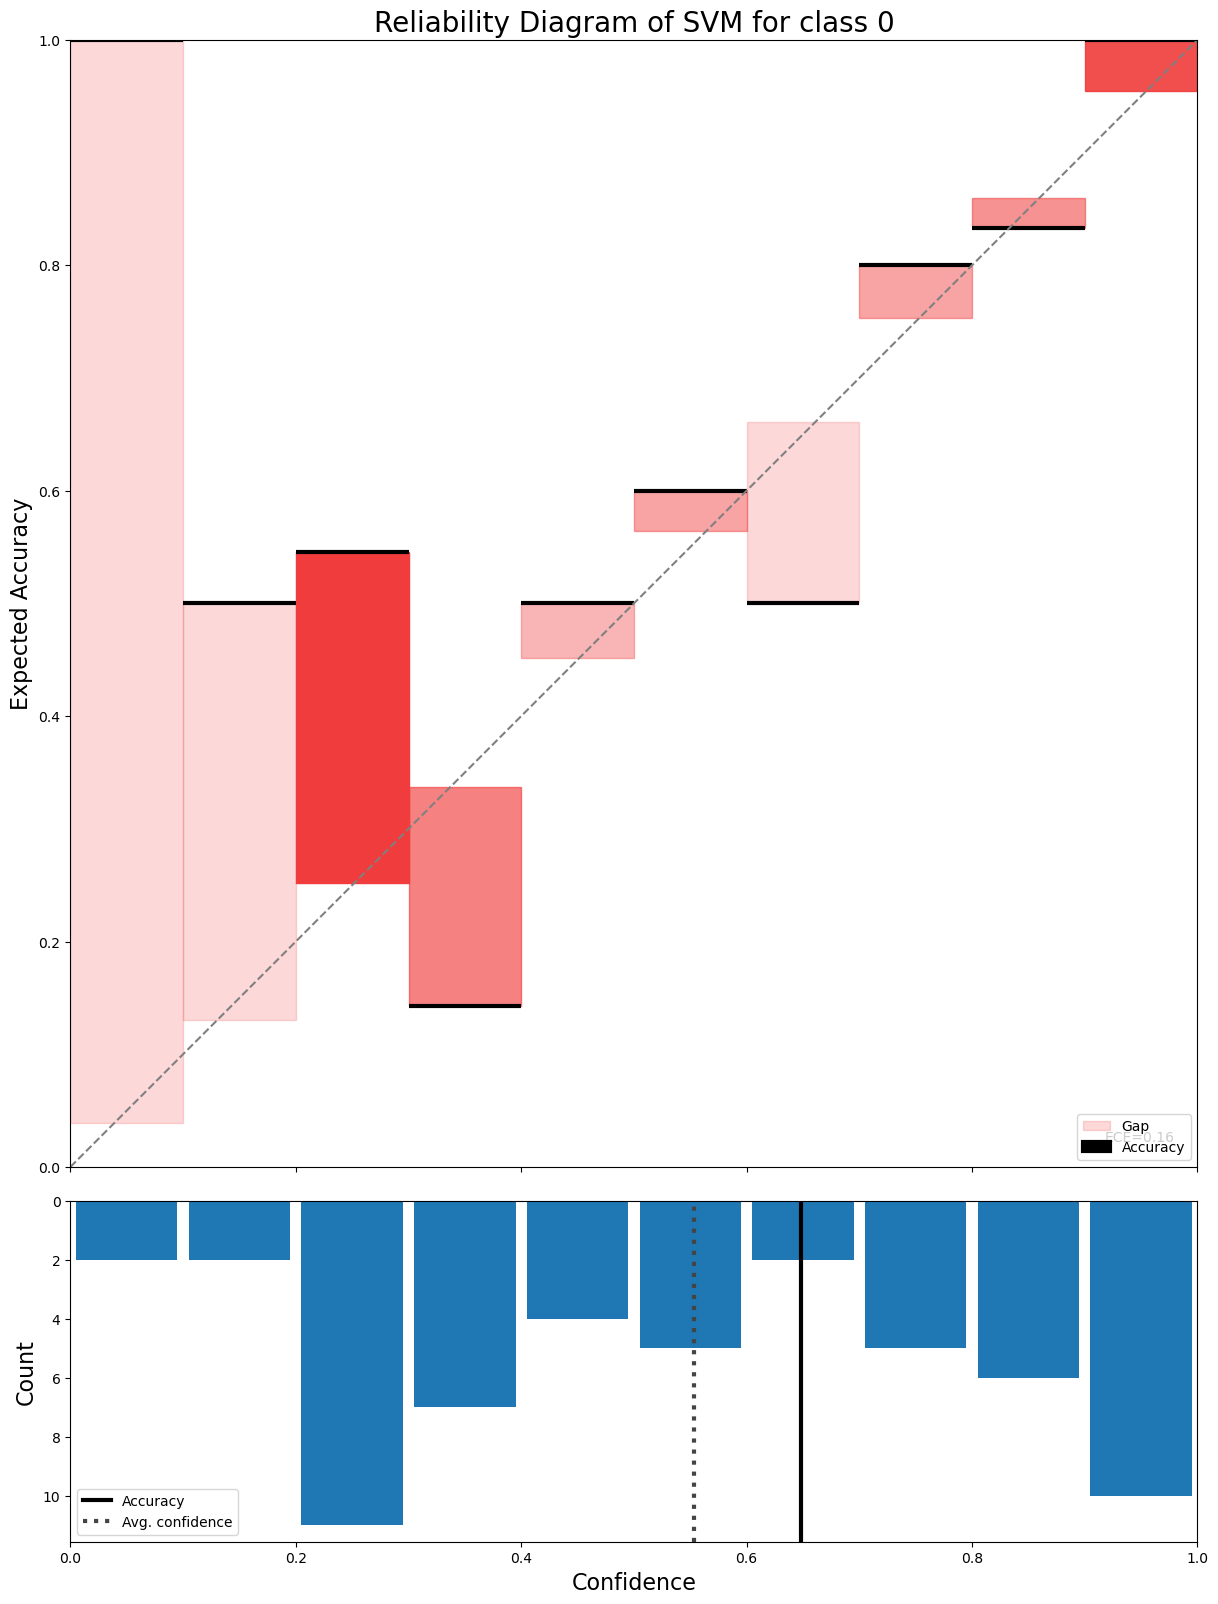

In [109]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of SVM for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of SVM for class 0.jpg", bbox_inches='tight')

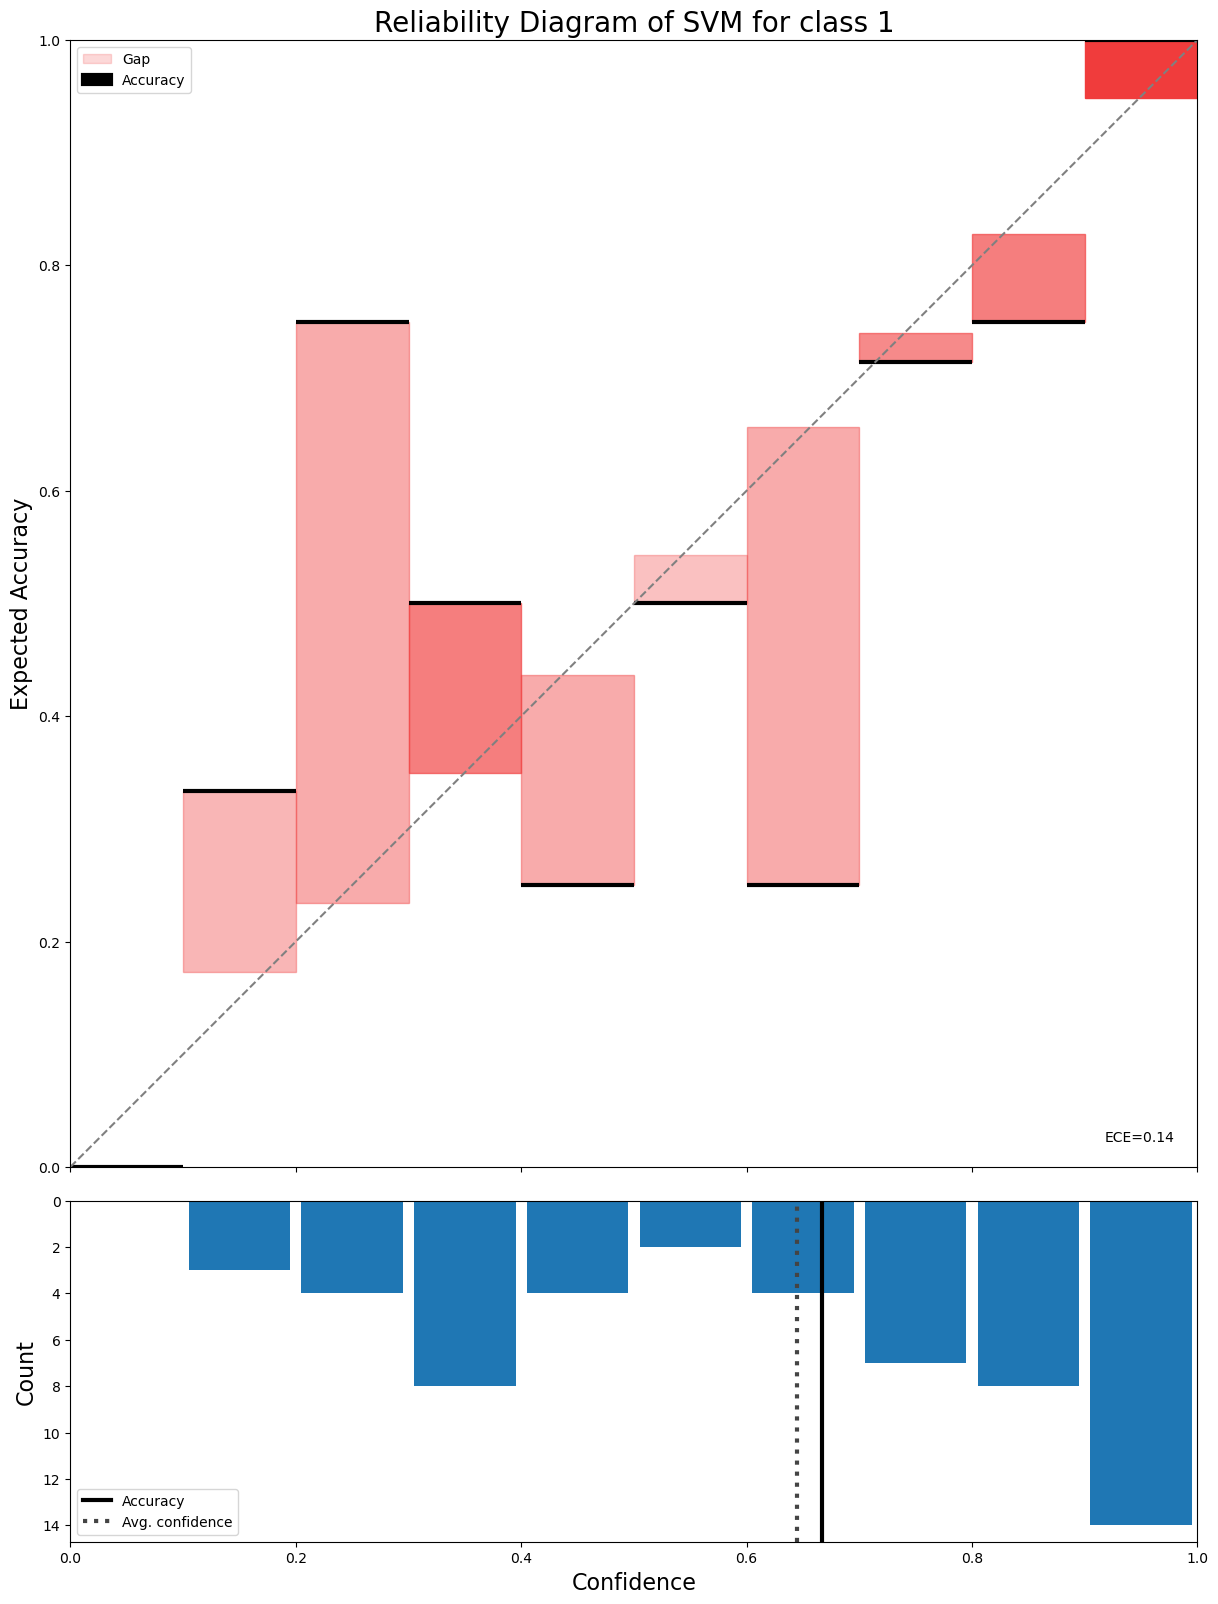

In [110]:
fig = reliability_diagram(y_test, y_hat, y_probs_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of SVM for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of SVM for class 1.jpg", bbox_inches='tight')

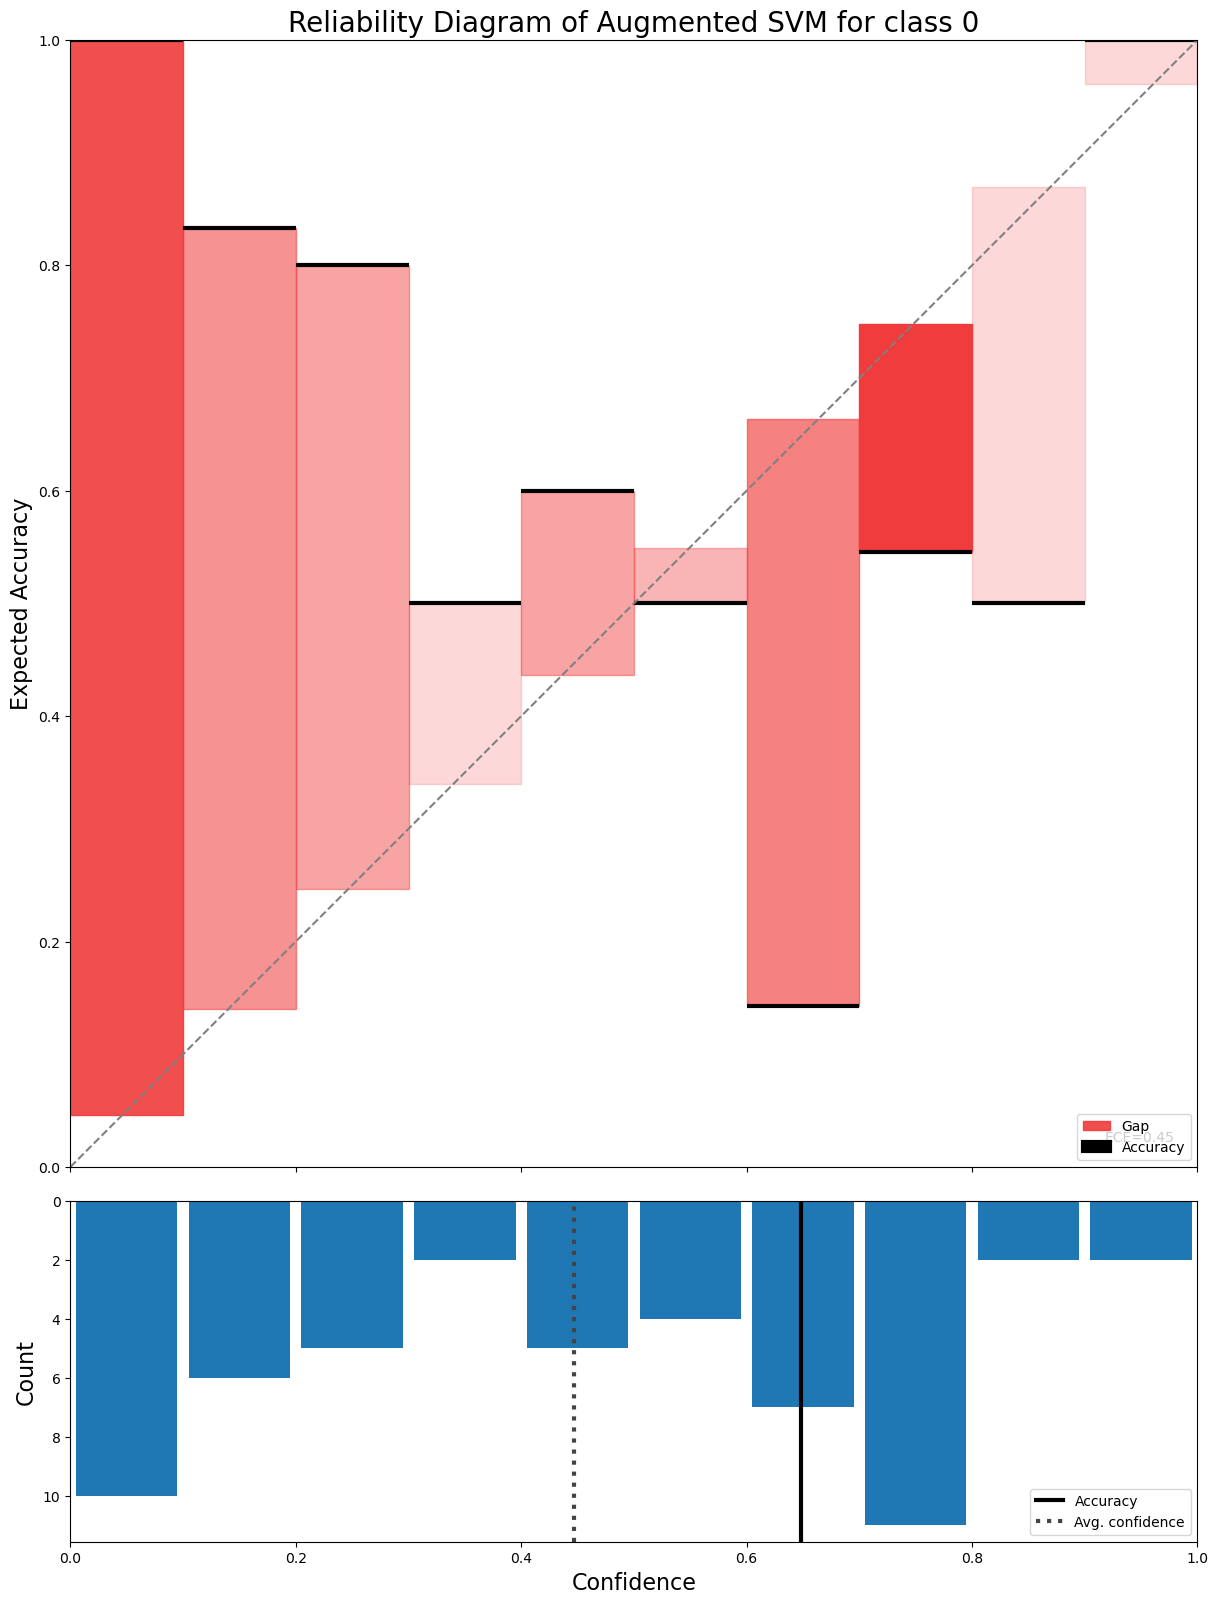

In [111]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Augmented SVM for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of Augmented SVM for class 0.jpg", bbox_inches='tight')

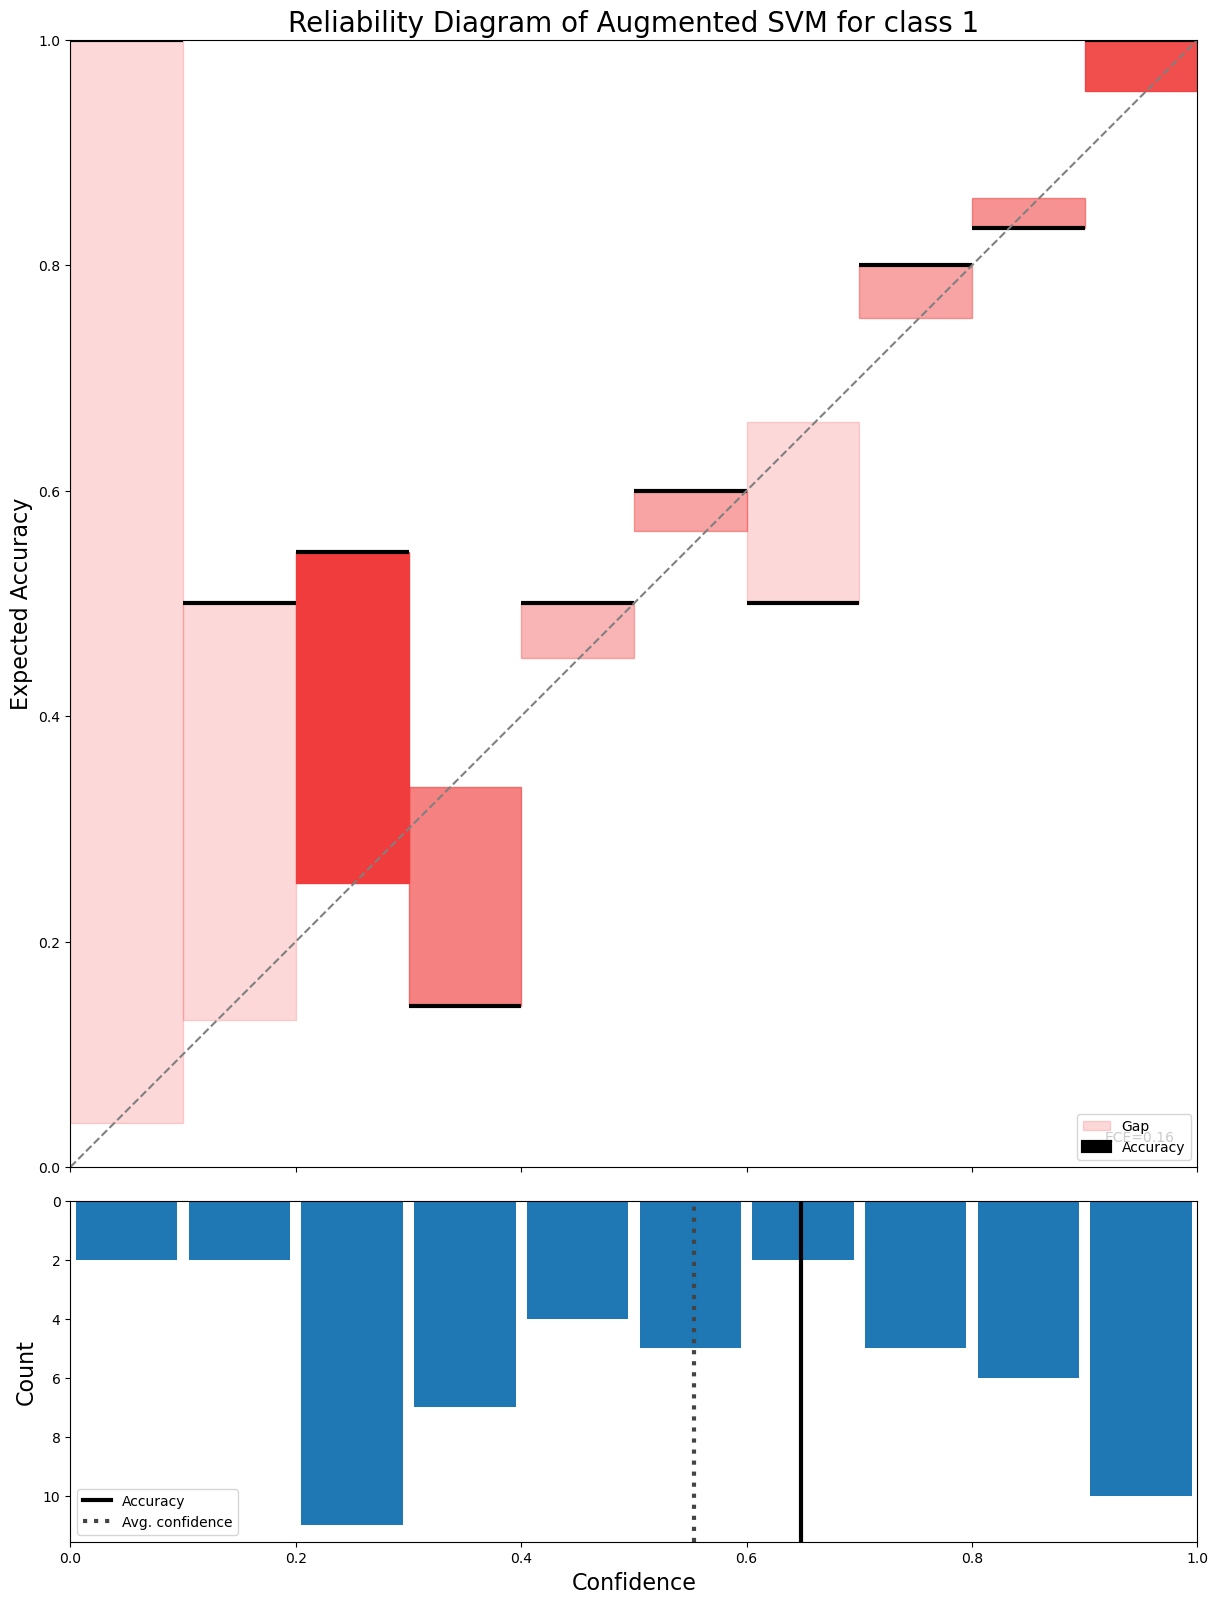

In [112]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Augmented SVM for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of Augmented SVM for class 1.jpg", bbox_inches='tight')

In [114]:
print(cv2.__version__)

4.5.5
